In [3]:
import numpy as np
import random
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eda_utils.data_exporation import *

# Evaluating Overall Data Structure
[Link to Data](https://zenodo.org/records/8028045)
- The purpose of this section is to observe the overall structure of the HDF5 file. HDF5 files can differing formats so I am trying to identify the computationally visualize data structure from what is represented in the text description of the data source.
- What I've found within the file is that there is a representative hierarchy in labels within the anomalous labeled data as mentioned within the text. We can see the array sizes and how each grouping of data is represented. 
- I identified that there are no labels within our train_data, which leads me to conclude we will be working with a semi supervised learning problem, especially with the small amount of labeled that we do have relative to anomalous occurrences. 

In [4]:
file_path = "./data/ROAD_dataset.h5"

In [5]:
inspect_h5_file('./data/ROAD_dataset.h5')

<HDF5 file "ROAD_dataset.h5" (mode r)>
anomaly_data: <HDF5 group "/anomaly_data" (9 members)>
anomaly_data/first_order_data_loss: <HDF5 group "/anomaly_data/first_order_data_loss" (5 members)>
anomaly_data/first_order_data_loss/data: <HDF5 dataset "data": shape (146, 256, 256, 4), type "<f4">
anomaly_data/first_order_data_loss/frequency_band: <HDF5 dataset "frequency_band": shape (146, 256, 256, 1), type "<f4">
anomaly_data/first_order_data_loss/ids: <HDF5 dataset "ids": shape (146,), type "|S100">
anomaly_data/first_order_data_loss/labels: <HDF5 dataset "labels": shape (146,), type "|S100">
anomaly_data/first_order_data_loss/source: <HDF5 dataset "source": shape (146,), type "|S100">
anomaly_data/first_order_high_noise: <HDF5 group "/anomaly_data/first_order_high_noise" (5 members)>
anomaly_data/first_order_high_noise/data: <HDF5 dataset "data": shape (88, 256, 256, 4), type "<f4">
anomaly_data/first_order_high_noise/frequency_band: <HDF5 dataset "frequency_band": shape (88, 256, 256,

In [5]:
# Use this function to inspect train_data
file_path = './data/ROAD_dataset.h5'
data_group = 'anomaly_data/galactic_plane'
inspect_train_data(file_path, data_group)


Datasets in anomaly_data/galactic_plane:
data: shape=(550, 256, 256, 4), dtype=float32
frequency_band: shape=(550, 256, 256, 1), dtype=float32
ids: shape=(550,), dtype=|S100
labels: shape=(550,), dtype=|S100
source: shape=(550,), dtype=|S100


In [6]:
# trying to depict if there are any sort of labels associated with the training or the testing data
with h5py.File(file_path, 'r') as f:
    train_labels = f['train_data/labels'][:10]  # View the first 10 labels
    print("Sample labels:", [label.decode('utf-8') for label in train_labels])

Sample labels: ['', '', '', '', '', '', '', '', '', '']


In [7]:
with h5py.File(file_path, 'r') as f:
    for group_name in ['train_data', 'test_data', 'anomaly_data', 'anomaly_data/first_order_data_loss','anomaly_data/first_order_high_noise','anomaly_data/galactic_plane', 'anomaly_data/lightning','anomaly_data/oscillating_tile','anomaly_data/rfi_ionosphere_reflect','anomaly_data/solar_storm','anomaly_data/source_in_sidelobes','anomaly_data/third_order_data_loss']:
        if group_name in f:
            print(f"\nContents of Group: {group_name}")
            group = f[group_name]
            for key in group.keys():
                item = group[key]
                if isinstance(item, h5py.Dataset):
                    print(f"  Dataset: {key}, Shape: {item.shape}, Dtype: {item.dtype}")
                elif isinstance(item, h5py.Group):
                    print(f"  Subgroup: {key}")
                else:
                    print(f"  Unknown item: {key}")
        else:
            print(f"Group {group_name} not found in the file.")



Contents of Group: train_data
  Dataset: data, Shape: (3687, 256, 256, 4), Dtype: float32
  Dataset: frequency_band, Shape: (3687, 256, 256, 1), Dtype: float32
  Dataset: ids, Shape: (3687,), Dtype: |S100
  Dataset: labels, Shape: (3687,), Dtype: |S100
  Dataset: source, Shape: (3687,), Dtype: |S100

Contents of Group: test_data
  Dataset: data, Shape: (1000, 256, 256, 4), Dtype: float32
  Dataset: frequency_band, Shape: (1000, 256, 256, 1), Dtype: float32
  Dataset: ids, Shape: (1000,), Dtype: |S100
  Dataset: labels, Shape: (1000,), Dtype: |S100
  Dataset: source, Shape: (1000,), Dtype: |S100

Contents of Group: anomaly_data
  Subgroup: first_order_data_loss
  Subgroup: first_order_high_noise
  Subgroup: galactic_plane
  Subgroup: lightning
  Subgroup: oscillating_tile
  Subgroup: rfi_ionosphere_reflect
  Subgroup: solar_storm
  Subgroup: source_in_sidelobes
  Subgroup: third_order_data_loss

Contents of Group: anomaly_data/first_order_data_loss
  Dataset: data, Shape: (146, 256, 25

In [8]:
# 4 dimensions time, frequency, polarisation, and baseline

# Evaluating Groups within Data for EDA

#### Intializing Functions to use for EDA

In [9]:
def load_h5_data(file_path, group_name):
    with h5py.File(file_path, 'r') as f:
        data = np.array(f[group_name]['data'])
        labels = np.array(f[group_name]['labels'], dtype=str)
        ids = np.array(f[group_name]['ids'], dtype=str)
        source = np.array(f[group_name]['source'], dtype=str)
        frequency_band = np.array(f[group_name]['frequency_band'])
    return data, labels, ids, source, frequency_band




In [10]:
def stat_summ_print(data, labels, ids, source, frequency_band):
    print(f"Data Shape: {data.shape}")
    print(f"Summary for Data: Min:{data.min()}, Max:{data.max()}, Mean: {data.mean()}, Std: {data.std()}")
    print(f"Summary for Frequency Band: Min:{frequency_band.min()}, Max:{frequency_band.max()}, Mean: {frequency_band.mean()}, Std: {frequency_band.std()}")
    unique_values, counts = np.unique(source, return_counts = True)
    print(f"Number of Unique Sources: {np.sum(counts)}")
    print(f"Label: {labels[0]}, ID Counts: {len(ids)}")

In [11]:
def flatten_data(data, freq_band):
    time_flatten = data[:, :, :, 0].flatten()        # Flatten to 1D array
    frequency_flatten = data[:, :, :, 1].flatten()
    polarization_flatten = data[:, :, :, 2].flatten()
    baseline_flatten = data[:, :, :, 3].flatten()
    freq_band = freq_band[:, :, :, 0].flatten()
    return time_flatten, frequency_flatten, polarization_flatten, baseline_flatten, freq_band


In [12]:
def flatten_data_index(data, freq_band, value):
    time_flatten = data[value, :, :, 0].flatten()        # Flatten to 1D array
    frequency_flatten = data[value, :, :, 1].flatten()
    polarization_flatten = data[value, :, :, 2].flatten()
    baseline_flatten = data[value, :, :, 3].flatten()
    freq_band = freq_band[value, :, :, 0].flatten()
    return time_flatten, frequency_flatten, polarization_flatten, baseline_flatten, freq_band

In [13]:

# Combine all arrays into a list for pairwise plotting
def create_pairs_plot(time_flatten, frequency_flatten, polarization_flatten, baseline_flatten, freq_band):
    variables = [time_flatten, frequency_flatten, polarization_flatten, baseline_flatten, freq_band]
    names = ["Time", "Frequency", "Polarization", "Station", "Frequency Band"]

    # Set up the figure grid
    fig, axes = plt.subplots(len(variables), len(variables), figsize=(12, 12))

    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            if i == j:
                # Plot histogram on the diagonal
                axes[i, j].hist(var1, bins=30, color='gray', alpha=0.7)
                axes[i, j].set_title(names[i])
            else:
                # Plot scatter for pairwise combinations
                axes[i, j].scatter(var2, var1, alpha=0.5, s=1)
            
            # Set labels for rows and columns
            if j == 0:
                axes[i, j].set_ylabel(names[i])
            if i == len(variables) - 1:
                axes[i, j].set_xlabel(names[j])

    plt.tight_layout()
    plt.suptitle("Scatter Matrix of Channels", y=1.02)
    plt.show()


## first_order_data_loss

In [107]:
data_data_loss, labels_data_loss, ids_data_loss, source_data_loss, freq_band_data_loss = load_h5_data(file_path, "anomaly_data/first_order_data_loss")

In [124]:
print(np.where(np.isnan(freq_band_data_loss)))
print(np.where(np.isnan(data_data_loss)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [108]:
stat_summ_print(data_data_loss, labels_data_loss, ids_data_loss, source_data_loss, freq_band_data_loss)

Data Shape: (146, 256, 256, 4)
Summary for Data: Min:0.0, Max:422434603008.0, Mean: 70273424.0, Std: 1887865472.0
Summary for Frequency Band: Min:30273438.0, Max:187304688.0, Mean: 124522904.0, Std: 41241964.0
Number of Unique Sources: 146
Label: first_order_data_loss, ID Counts: 146


In [16]:
time_flatten_data_loss, frequency_flatten_data_loss, polarization_flatten_data_loss, baseline_flatten_data_loss, freq_band_flatten_data_loss = flatten_data(data_data_loss, freq_band_data_loss)

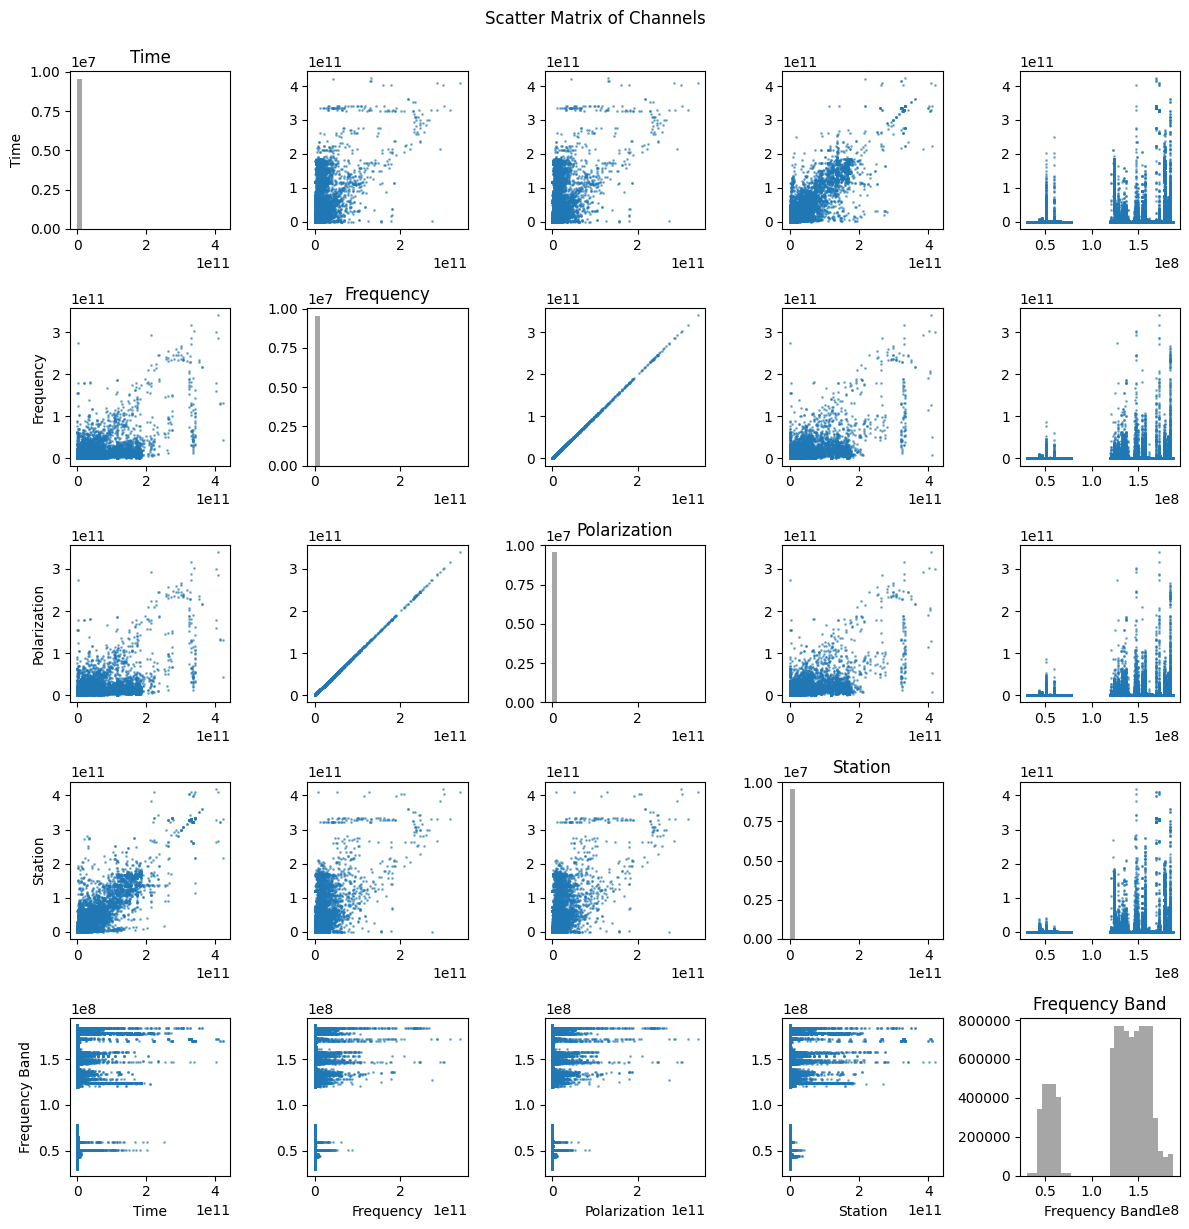

In [17]:
create_pairs_plot(time_flatten_data_loss, frequency_flatten_data_loss, polarization_flatten_data_loss, baseline_flatten_data_loss, freq_band_flatten_data_loss)

In [20]:
time_flatten_data_loss_idx, frequency_flatten_data_loss_idx, polarization_flatten_data_loss_idx, baseline_flatten_data_loss_idx, freq_band_flatten_data_loss_idx = flatten_data_index(data_data_loss,freq_band_data_loss, 0)

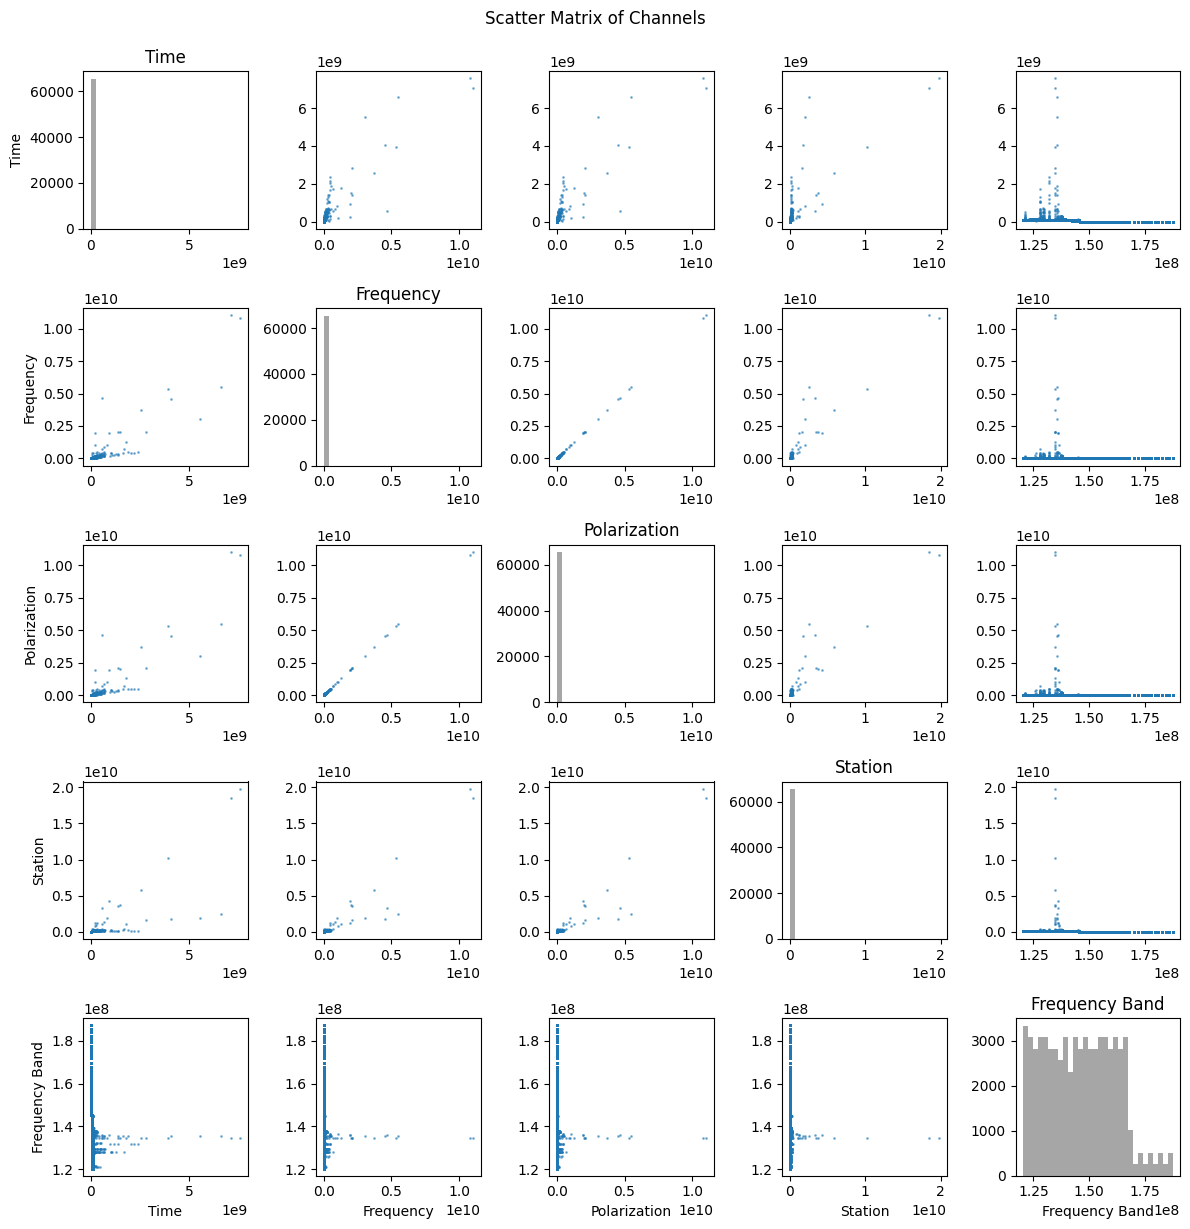

In [21]:
create_pairs_plot(time_flatten_data_loss_idx, frequency_flatten_data_loss_idx, polarization_flatten_data_loss_idx, baseline_flatten_data_loss_idx, freq_band_flatten_data_loss_idx)

## first_order_high_noise

In [28]:
data_high_noise, labels_high_noise, ids_high_noise, source_high_noise, freq_band_high_noise = load_h5_data(file_path, "anomaly_data/first_order_high_noise")

In [125]:
print(np.where(np.isnan(data_high_noise)))
print(np.where(np.isnan(freq_band_high_noise)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [29]:
stat_summ_print(data_high_noise, labels_high_noise, ids_high_noise, source_high_noise, freq_band_high_noise)

Data Shape: (88, 256, 256, 4)
Summary for Data: Min:1879.2215576171875, Max:485841371136.0, Mean: 2224713984.0, Std: 15504868352.0
Summary for Frequency Band: Min:9960938.0, Max:187304688.0, Mean: 94231344.0, Std: 48066068.0
Number of Unique Sources: 88
Label: first_order_high_noise, ID Counts: 88


In [25]:
time_flatten_high_noise, frequency_flatten_high_noise, polarization_flatten_high_noise, baseline_flatten_high_noise, freq_band_flatten_high_noise = flatten_data(data_high_noise, freq_band_high_noise)

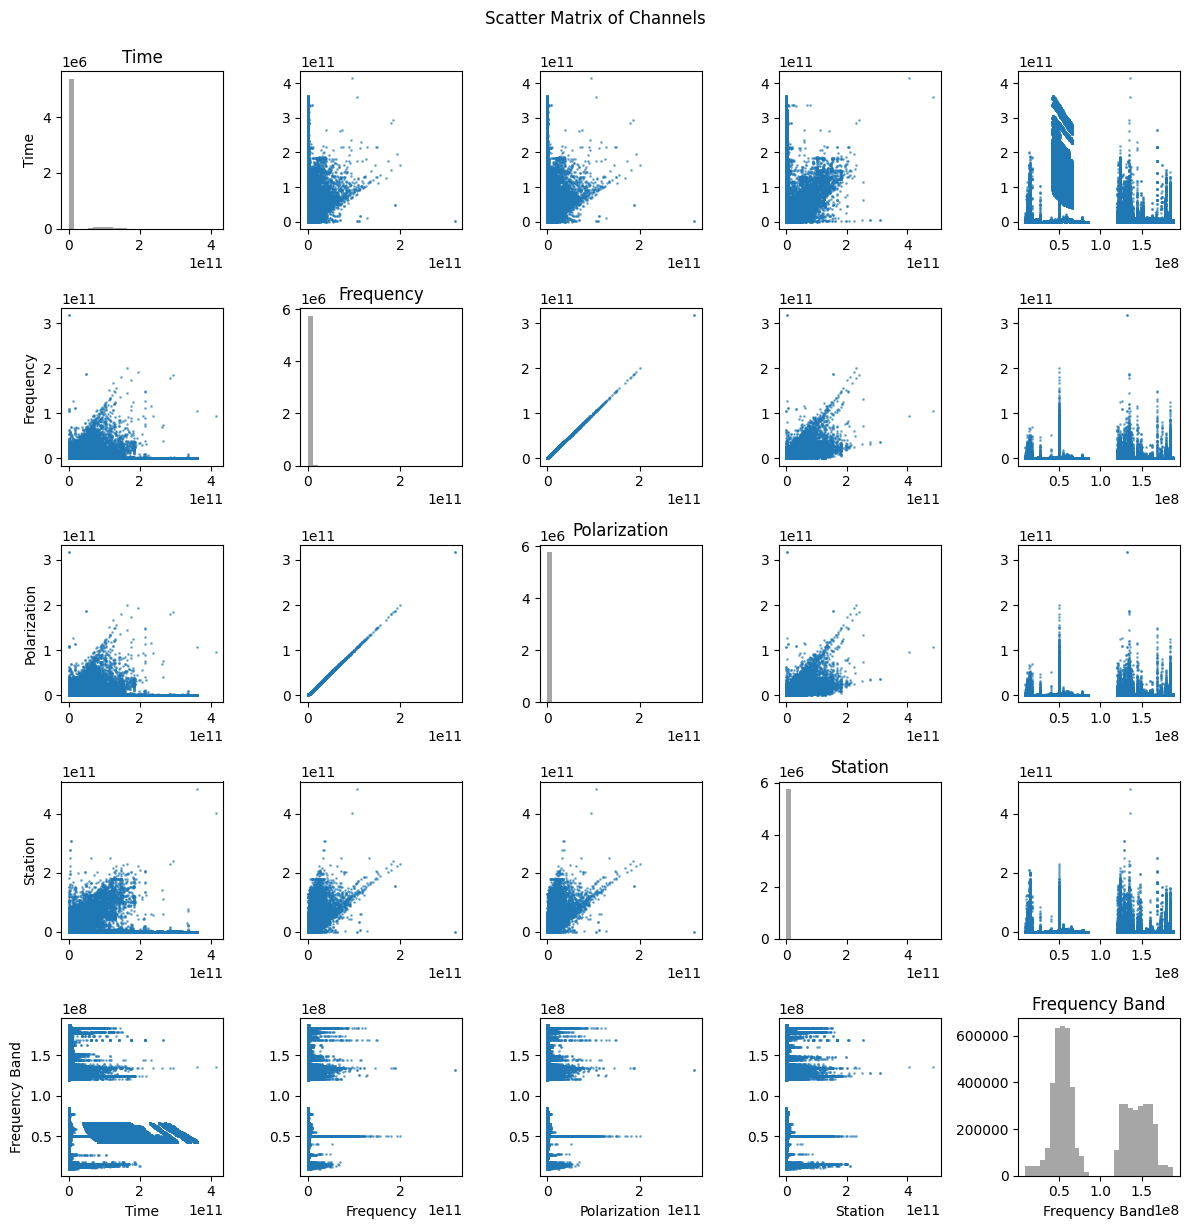

In [26]:
create_pairs_plot(time_flatten_high_noise, frequency_flatten_high_noise, polarization_flatten_high_noise, baseline_flatten_high_noise, freq_band_flatten_high_noise)

In [32]:
time_flatten_high_noise_idx, frequency_flatten_high_noise_idx, polarization_flatten_high_noise_idx, baseline_flatten_high_noise_idx, freq_band_flatten_high_noise_idx = flatten_data_index(data_high_noise,freq_band_high_noise, 2)

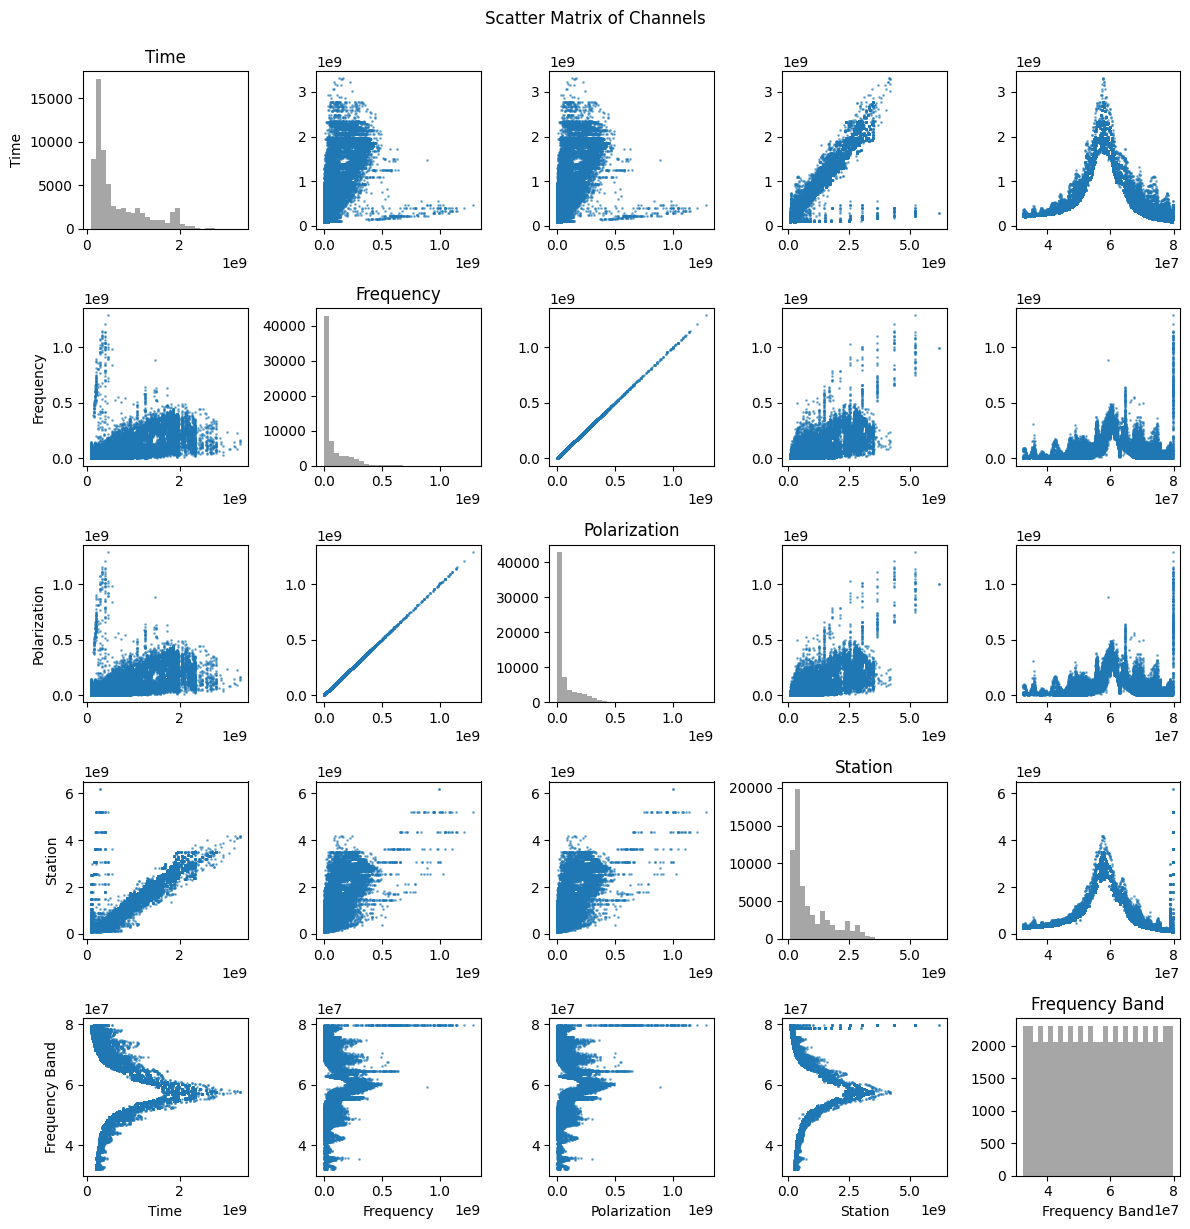

In [33]:
create_pairs_plot(time_flatten_high_noise_idx, frequency_flatten_high_noise_idx, polarization_flatten_high_noise_idx, baseline_flatten_high_noise_idx, freq_band_flatten_high_noise_idx)

## galactic_plane

In [34]:
data_galactic_plane, labels_galactic_plane, ids_galactic_plane, source_galactic_plane, freq_band_galactic_plane = load_h5_data(file_path, "anomaly_data/galactic_plane")

In [126]:
print(np.where(np.isnan(data_galactic_plane)))
print(np.where(np.isnan(freq_band_galactic_plane)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [35]:
stat_summ_print(data_galactic_plane, labels_galactic_plane, ids_galactic_plane, source_galactic_plane, freq_band_galactic_plane)

Data Shape: (550, 256, 256, 4)
Summary for Data: Min:0.0, Max:428420202496.0, Mean: 221697520.0, Std: 3175868160.0
Summary for Frequency Band: Min:119942096.0, Max:187304688.0, Mean: 145871744.0, Std: 15576784.0
Number of Unique Sources: 550
Label: galactic_plane, ID Counts: 550


In [37]:
time_flatten_galactic_plane, frequency_flatten_galactic_plane, polarization_flatten_galactic_plane, baseline_flatten_galactic_plane, freq_band_flatten_galactic_plane = flatten_data(data_galactic_plane, freq_band_galactic_plane)

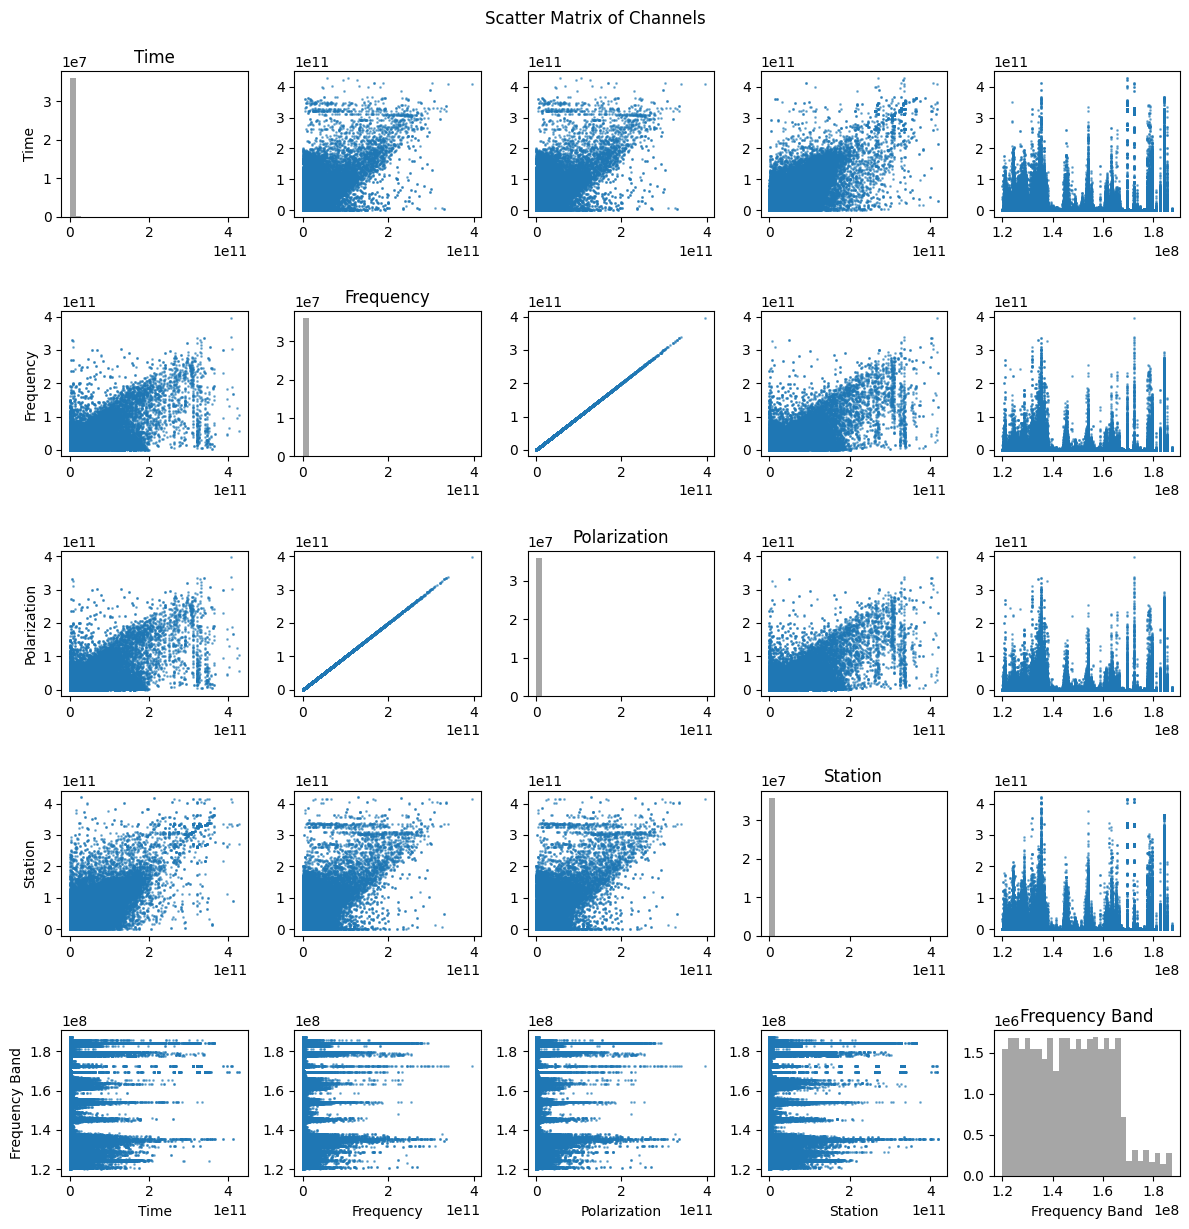

In [38]:
create_pairs_plot(time_flatten_galactic_plane, frequency_flatten_galactic_plane, polarization_flatten_galactic_plane, baseline_flatten_galactic_plane, freq_band_flatten_galactic_plane)

In [39]:
time_flatten_galactic_plane_idx, frequency_flatten_galactic_plane_idx, polarization_flatten_galactic_plane_idx, baseline_flatten_galactic_plane_idx, freq_band_flatten_galactic_plane_idx = flatten_data_index(data_galactic_plane,freq_band_galactic_plane, 0)

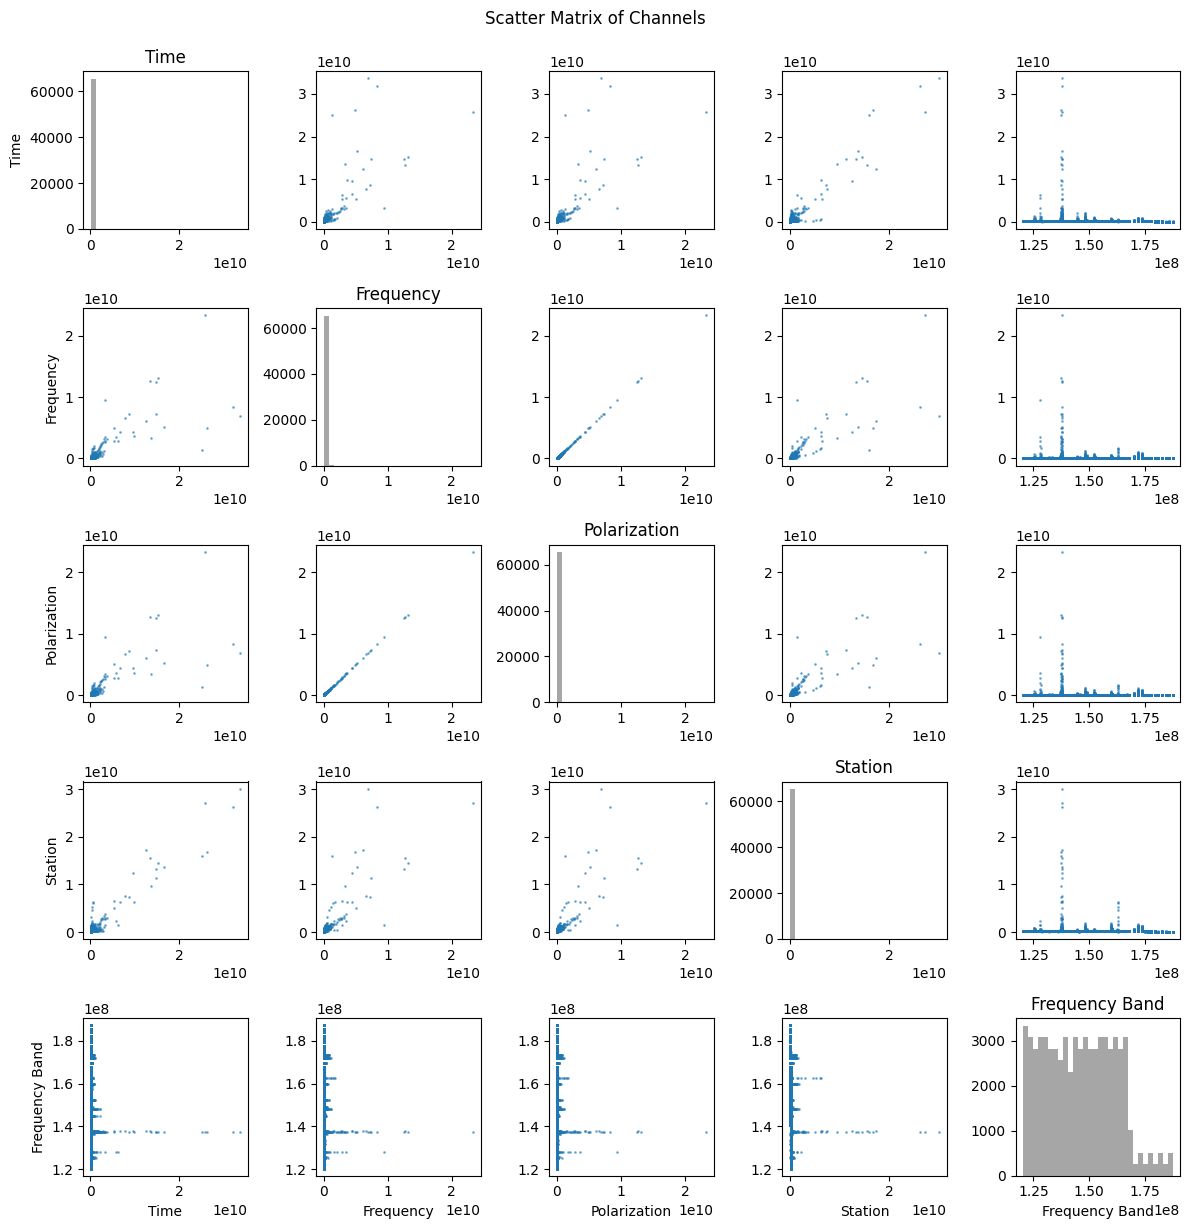

In [40]:
create_pairs_plot(time_flatten_galactic_plane_idx, frequency_flatten_galactic_plane_idx, polarization_flatten_galactic_plane_idx, baseline_flatten_galactic_plane_idx, freq_band_flatten_galactic_plane_idx)

## lightning

In [41]:
data_lightning, labels_lightning, ids_lightning, source_lightning, freq_band_lightning = load_h5_data(file_path, "anomaly_data/lightning")

In [127]:
print(np.where(np.isnan(data_lightning)))
print(np.where(np.isnan(freq_band_lightning)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [42]:
stat_summ_print(data_lightning, labels_lightning, ids_lightning, source_lightning, freq_band_lightning)

Data Shape: (389, 256, 256, 4)
Summary for Data: Min:0.0, Max:498347278336.0, Mean: 238789328.0, Std: 1706048640.0
Summary for Frequency Band: Min:9960938.0, Max:187304688.0, Mean: 99006744.0, Std: 48740416.0
Number of Unique Sources: 389
Label: lightning, ID Counts: 389


In [43]:
time_flatten_lightning, frequency_flatten_lightning, polarization_flatten_lightning, baseline_flatten_lightning, freq_band_flatten_lightning = flatten_data(data_lightning, freq_band_lightning)

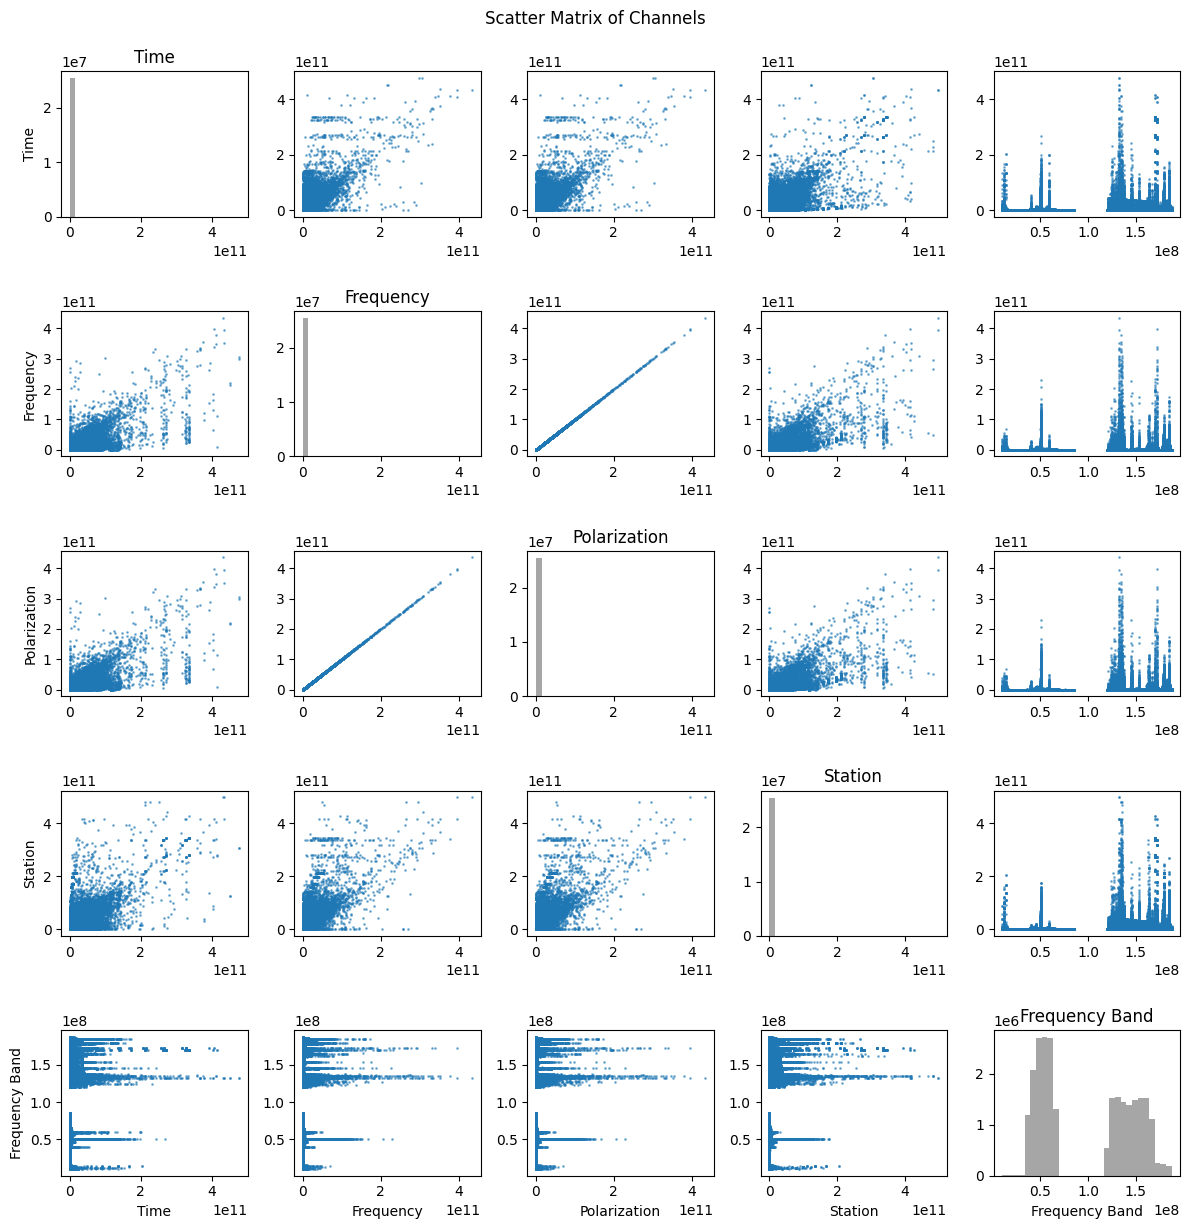

In [44]:
create_pairs_plot(time_flatten_lightning, frequency_flatten_lightning, polarization_flatten_lightning, baseline_flatten_lightning, freq_band_flatten_lightning)

In [45]:
time_flatten_lightning_idx, frequency_flatten_lightning_idx, polarization_flatten_lightning_idx, baseline_flatten_lightning_idx, freq_band_flatten_lightning_idx = flatten_data_index(data_lightning,freq_band_lightning, 0)

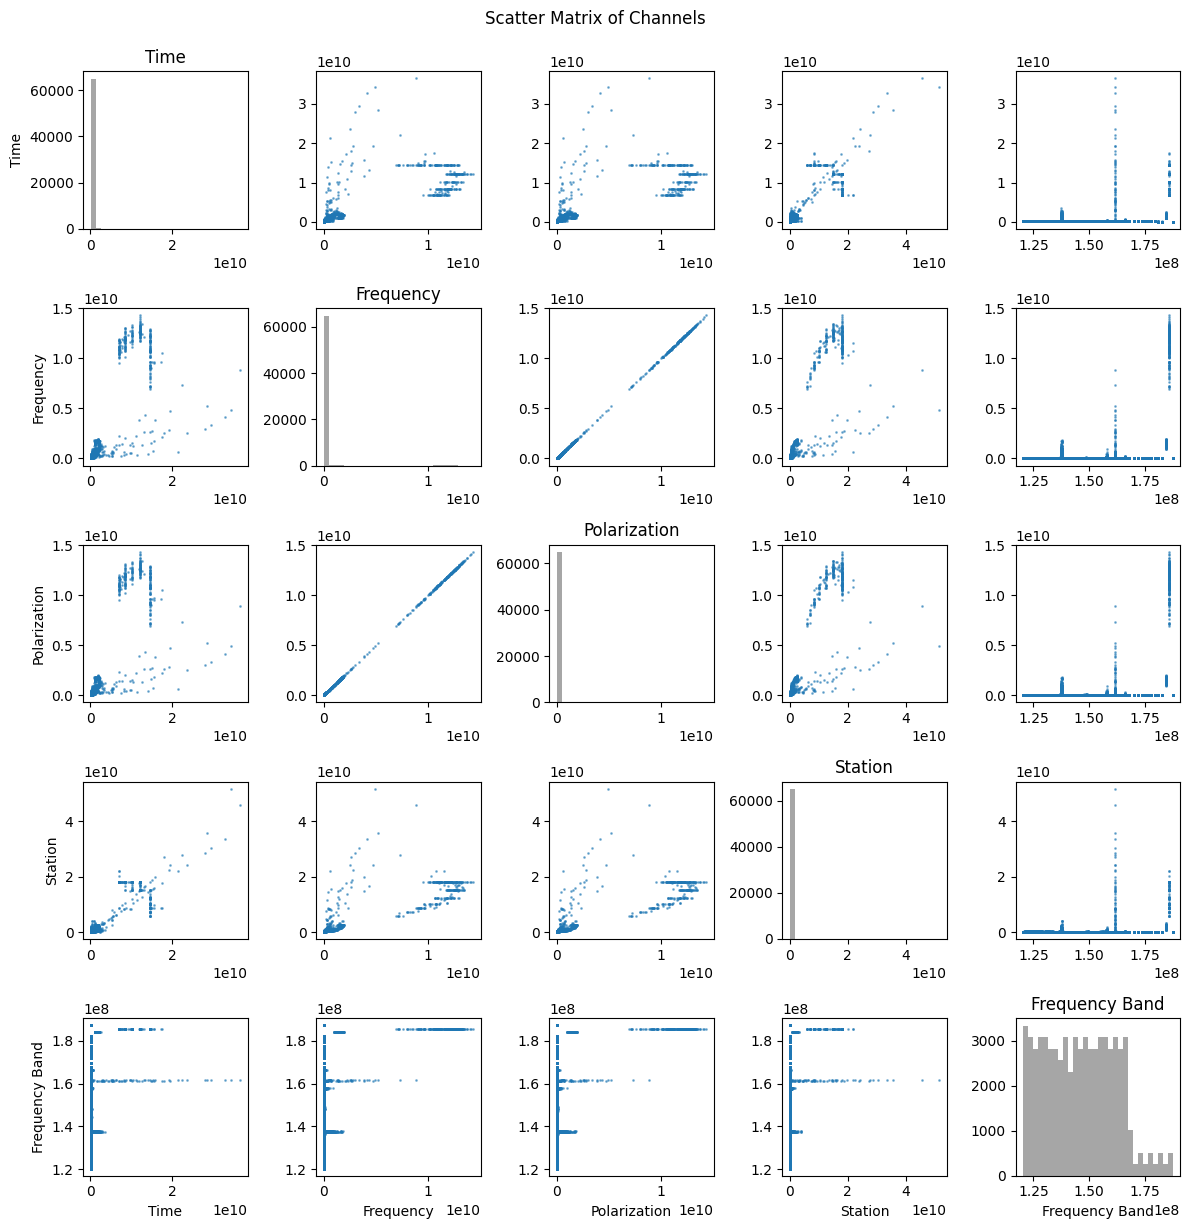

In [46]:
create_pairs_plot(time_flatten_lightning_idx, frequency_flatten_lightning_idx, polarization_flatten_lightning_idx, baseline_flatten_lightning_idx, freq_band_flatten_lightning_idx)

## oscillating_tile


In [47]:
data_oscillating_tile, labels_oscillating_tile, ids_oscillating_tile, source_oscillating_tile, freq_band_oscillating_tile = load_h5_data(file_path, "anomaly_data/oscillating_tile")

In [128]:
print(np.where(np.isnan(data_oscillating_tile)))
print(np.where(np.isnan(freq_band_oscillating_tile)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [48]:
stat_summ_print(data_oscillating_tile, labels_oscillating_tile, ids_oscillating_tile, source_oscillating_tile, freq_band_oscillating_tile)

Data Shape: (56, 256, 256, 4)
Summary for Data: Min:15842.0380859375, Max:530186240000.0, Mean: 747076288.0, Std: 8237839872.0
Summary for Frequency Band: Min:119942096.0, Max:187304688.0, Mean: 145914096.0, Std: 15596050.0
Number of Unique Sources: 56
Label: oscillating_tile, ID Counts: 56


In [49]:
time_flatten_oscillating_tile, frequency_flatten_oscillating_tile, polarization_flatten_oscillating_tile, baseline_flatten_oscillating_tile, freq_band_flatten_oscillating_tile = flatten_data(data_oscillating_tile, freq_band_oscillating_tile)

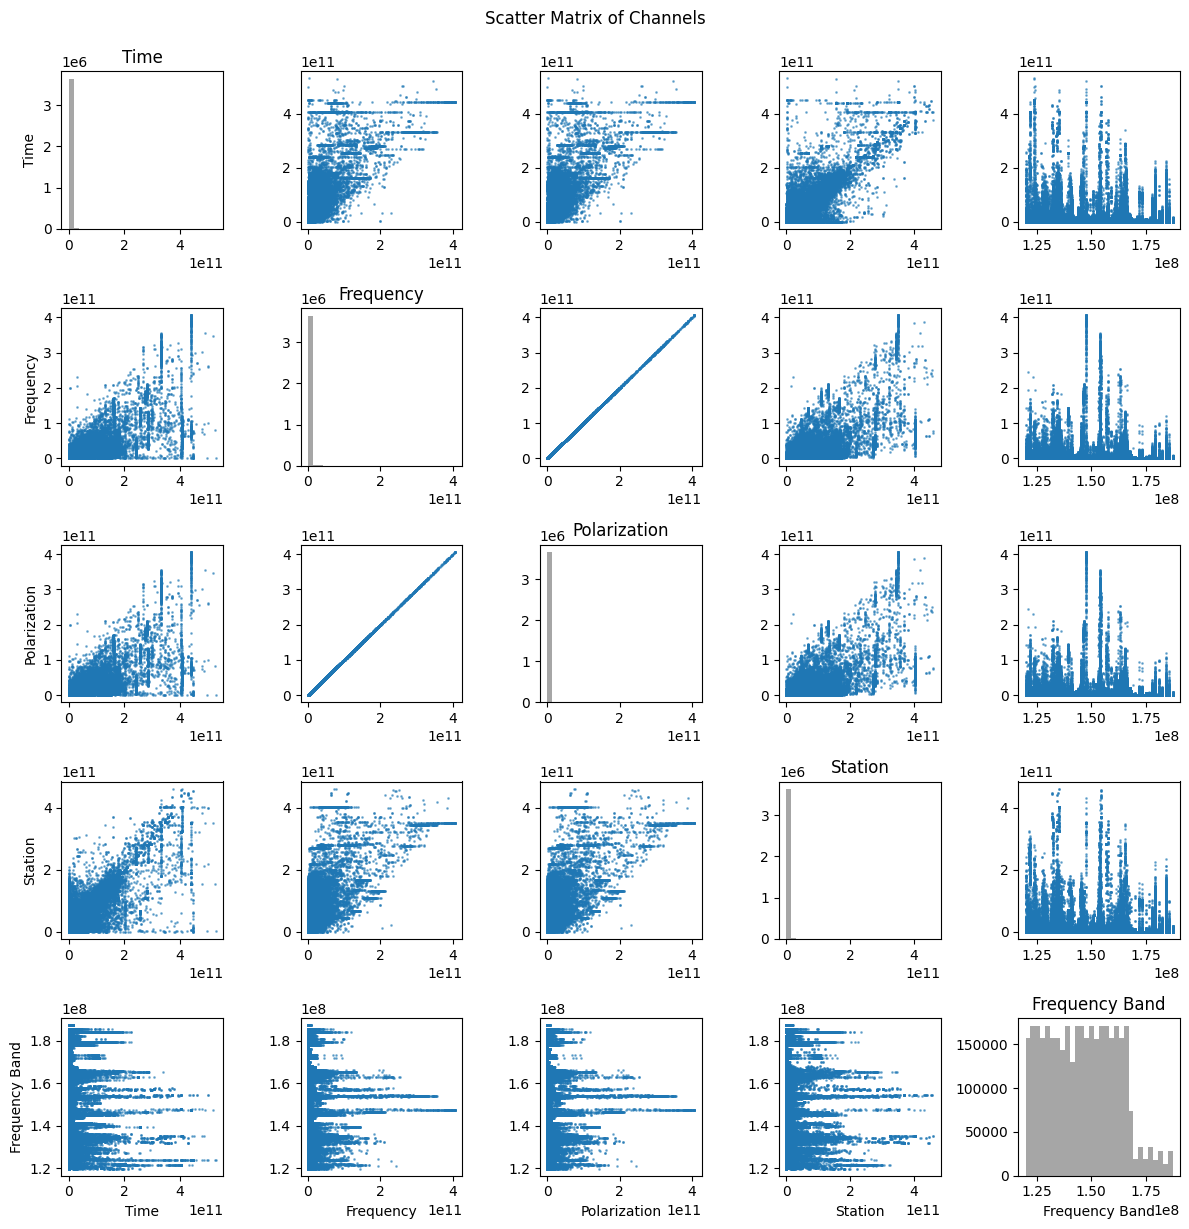

In [50]:
create_pairs_plot(time_flatten_oscillating_tile, frequency_flatten_oscillating_tile, polarization_flatten_oscillating_tile, baseline_flatten_oscillating_tile, freq_band_flatten_oscillating_tile)

In [51]:
time_flatten_oscillating_tile_idx, frequency_flatten_oscillating_tile_idx, polarization_flatten_oscillating_tile_idx, baseline_flatten_oscillating_tile_idx, freq_band_flatten_oscillating_tile_idx = flatten_data_index(data_oscillating_tile,freq_band_oscillating_tile, 0)

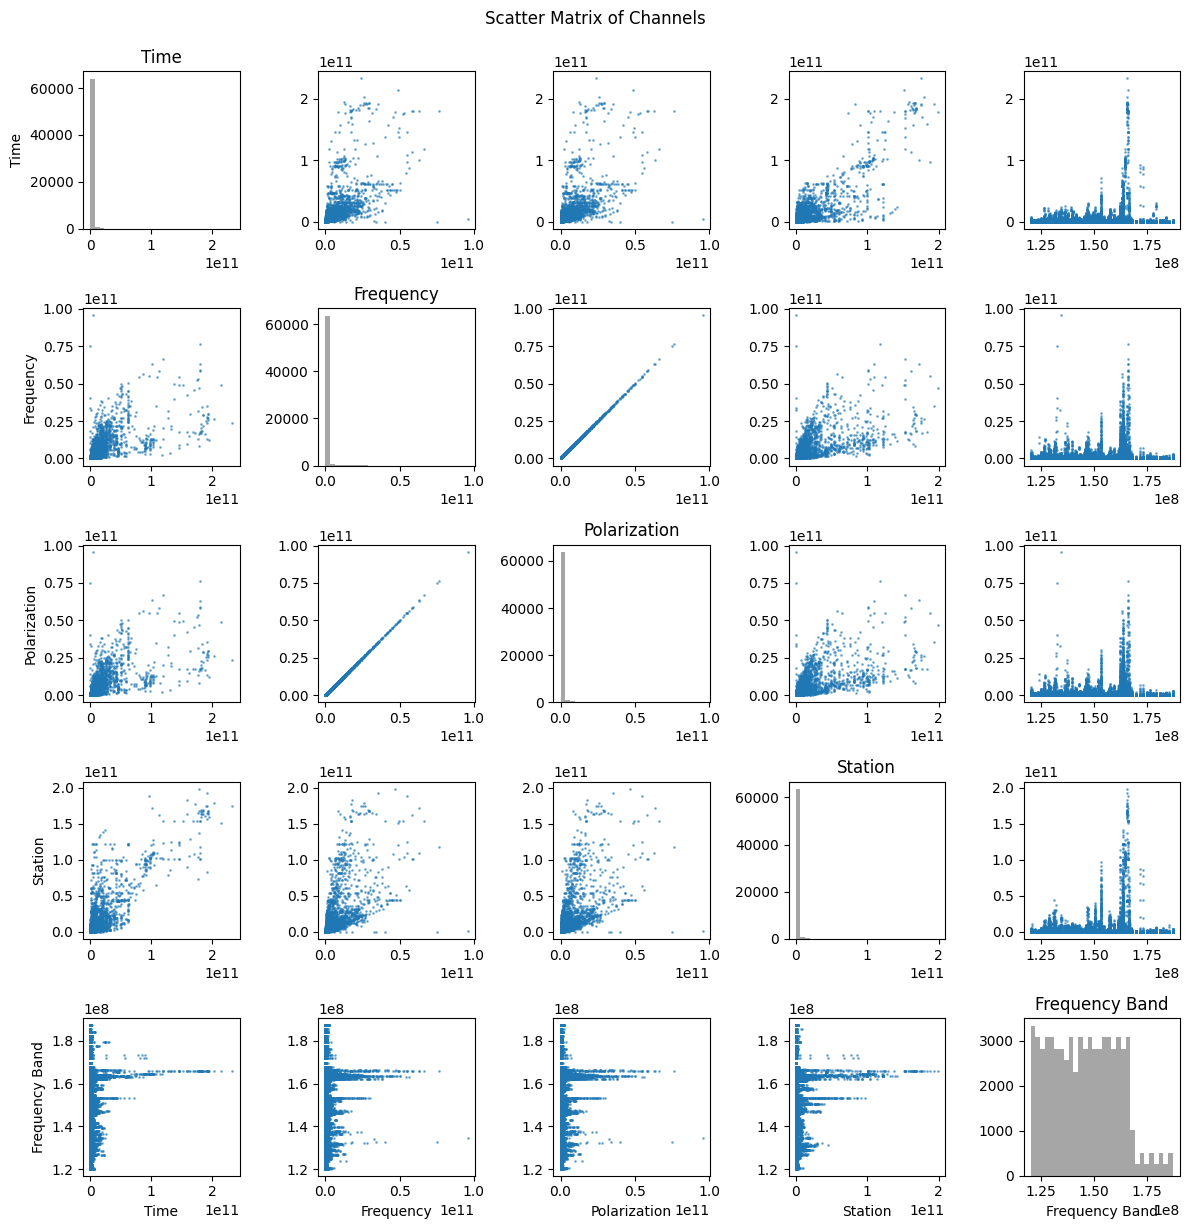

In [52]:
create_pairs_plot(time_flatten_oscillating_tile_idx, frequency_flatten_oscillating_tile_idx, polarization_flatten_oscillating_tile_idx, baseline_flatten_oscillating_tile_idx, freq_band_flatten_oscillating_tile_idx)

## rfi_ionosphere_reflect

In [67]:
data_rfi, labels_rfi, ids_rfi, source_rfi, freq_band_rfi = load_h5_data(file_path, "anomaly_data/rfi_ionosphere_reflect")

In [129]:
print(np.where(np.isnan(data_rfi)))
print(np.where(np.isnan(freq_band_rfi)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [68]:
stat_summ_print(data_rfi, labels_rfi, ids_rfi, source_rfi, freq_band_rfi)

Data Shape: (261, 256, 256, 4)
Summary for Data: Min:534.0811157226562, Max:583260635136.0, Mean: 546314624.0, Std: 5729077248.0
Summary for Frequency Band: Min:9960938.0, Max:84765624.0, Mean: 41591404.0, Std: 22435518.0
Number of Unique Sources: 261
Label: electric_fence-rfi_ionosphere_reflect, ID Counts: 261


In [69]:
time_flatten_rfi, frequency_flatten_rfi, polarization_flatten_rfi, baseline_flatten_rfi, freq_band_flatten_rfi = flatten_data(data_rfi, freq_band_rfi)

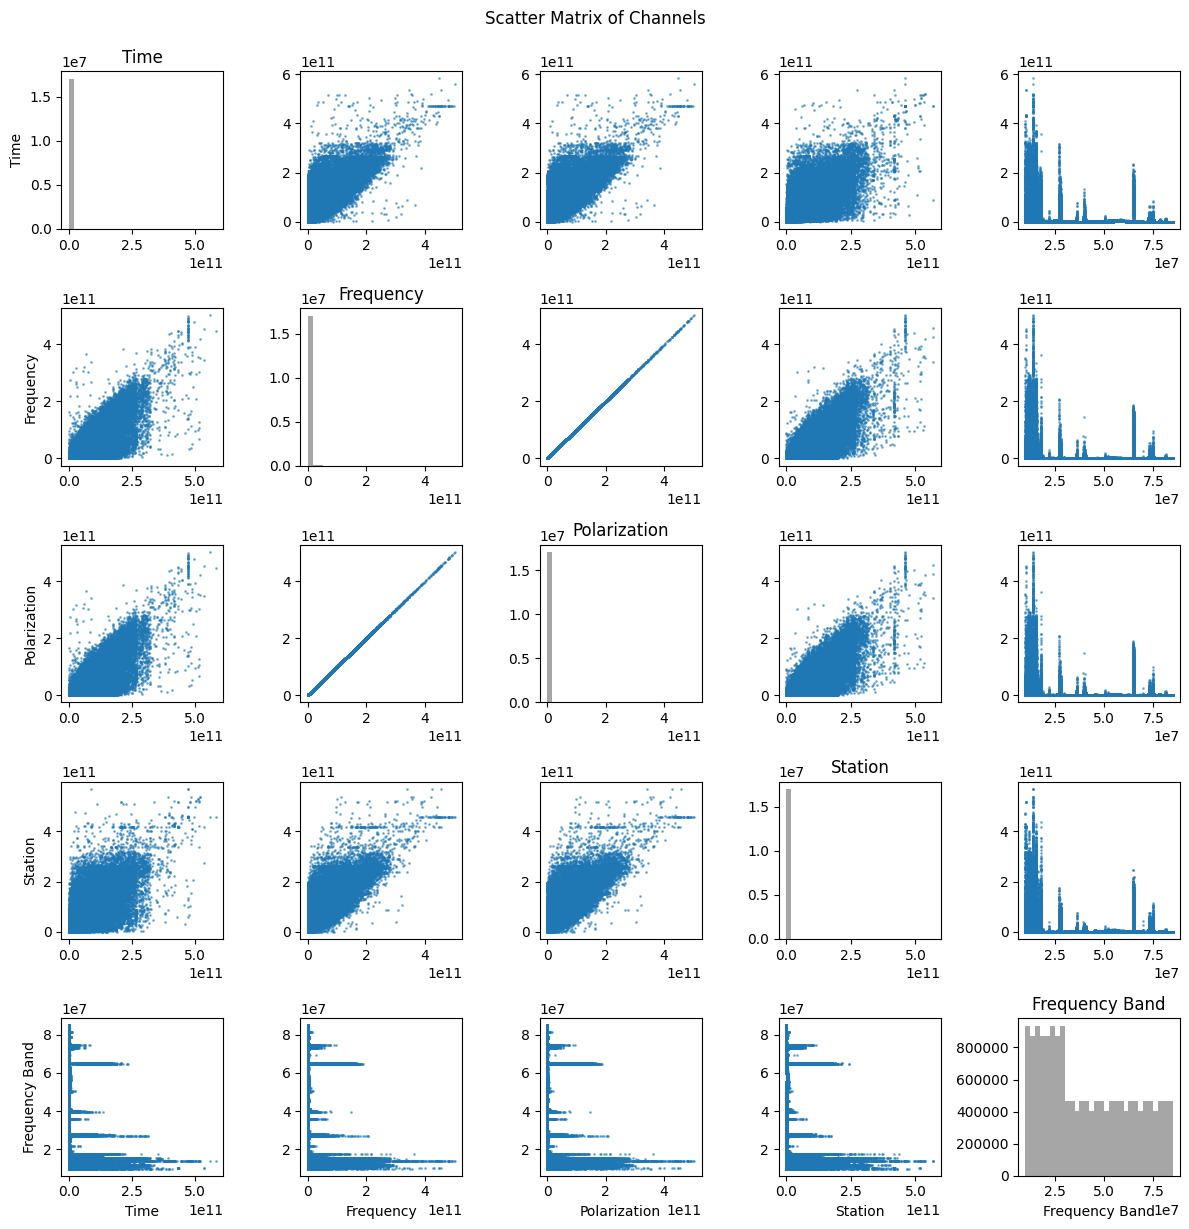

In [70]:
create_pairs_plot(time_flatten_rfi, frequency_flatten_rfi, polarization_flatten_rfi, baseline_flatten_rfi, freq_band_flatten_rfi)

In [75]:
time_flatten_rfi_idx, frequency_flatten_rfi_idx, polarization_flatten_rfi_idx, baseline_flatten_rfi_idx, freq_band_flatten_rfi_idx = flatten_data_index(data_rfi,freq_band_rfi, 0)

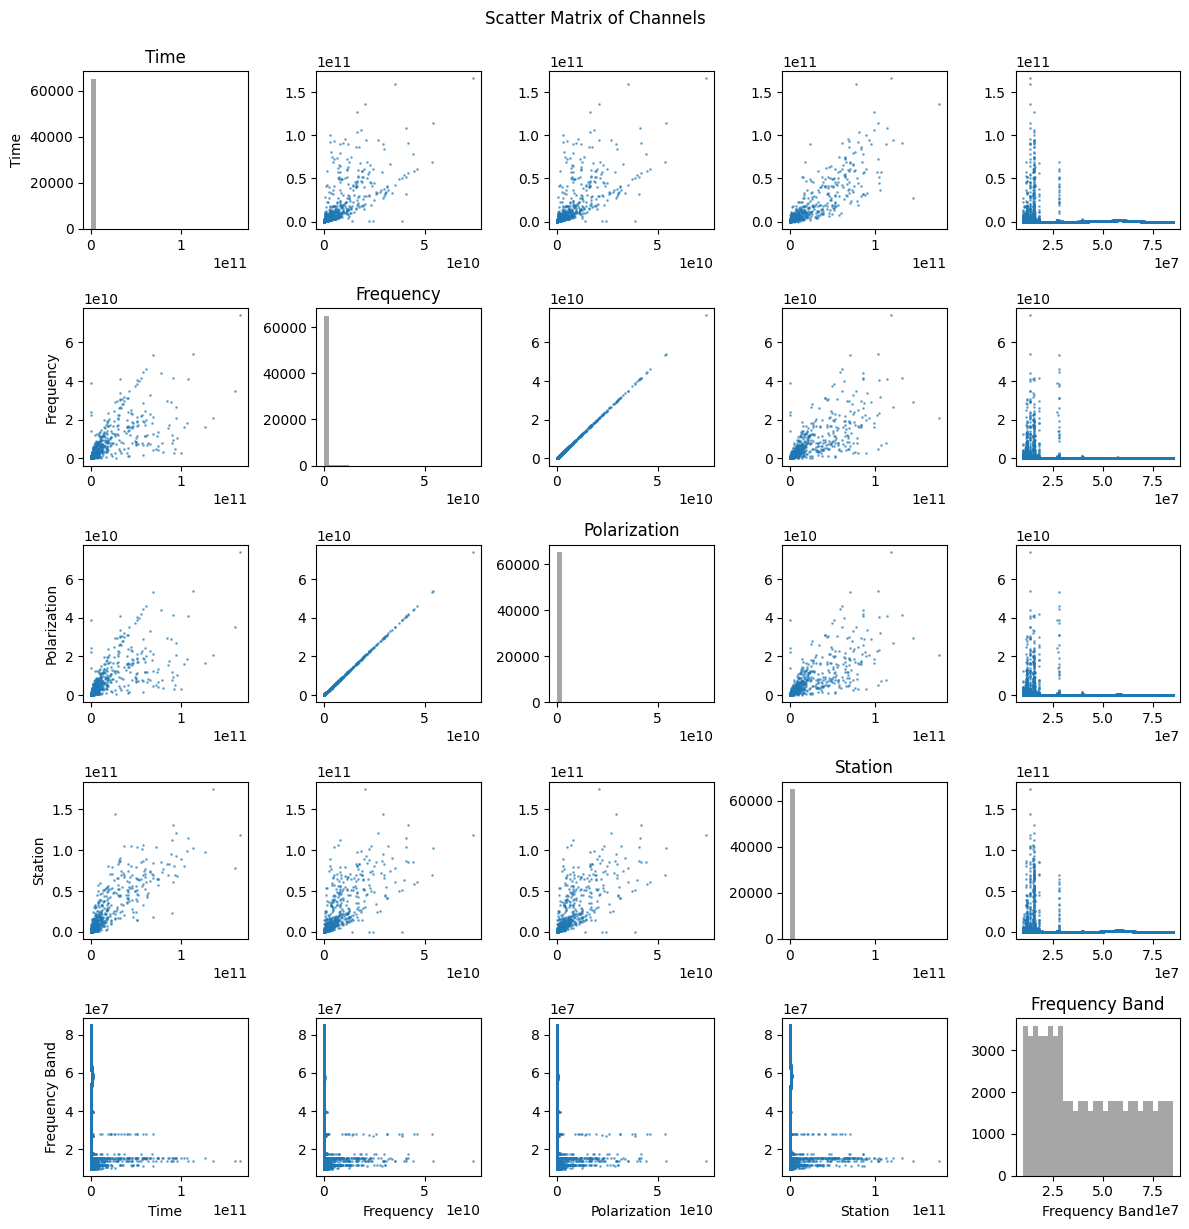

In [76]:
create_pairs_plot(time_flatten_rfi_idx, frequency_flatten_rfi_idx, polarization_flatten_rfi_idx, baseline_flatten_rfi_idx, freq_band_flatten_rfi_idx)

## solar_storm

In [77]:
data_solar, labels_solar, ids_solar, source_solar, freq_band_solar = load_h5_data(file_path, "anomaly_data/solar_storm")

In [130]:
print(np.where(np.isnan(data_solar)))
print(np.where(np.isnan(freq_band_solar)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [78]:
stat_summ_print(data_solar, labels_solar, ids_solar, source_solar, freq_band_solar)

Data Shape: (147, 256, 256, 4)
Summary for Data: Min:49163.36328125, Max:26570764288.0, Mean: 375478880.0, Std: 489647040.0
Summary for Frequency Band: Min:42382812.0, Max:66015624.0, Mean: 54177072.0, Std: 6872186.5
Number of Unique Sources: 147
Label: solar_storm, ID Counts: 147


In [79]:
time_flatten_solar, frequency_flatten_solar, polarization_flatten_solar, baseline_flatten_solar, freq_band_flatten_solar = flatten_data(data_solar, freq_band_solar)

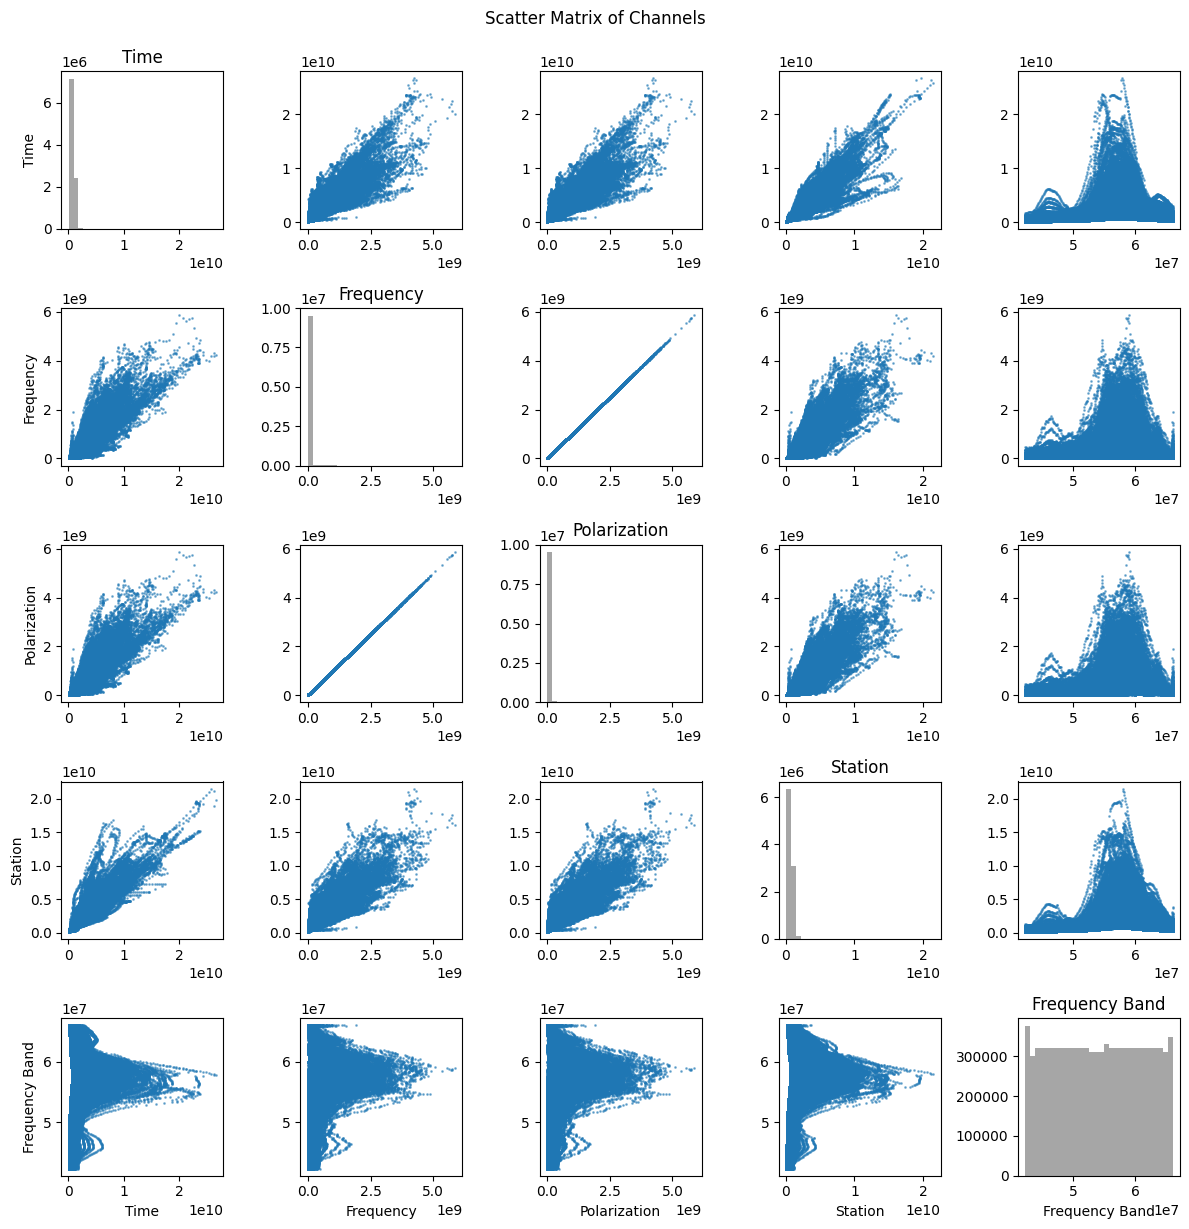

In [80]:
create_pairs_plot(time_flatten_solar, frequency_flatten_solar, polarization_flatten_solar, baseline_flatten_solar, freq_band_flatten_solar)

In [81]:
time_flatten_solar_idx, frequency_flatten_solar_idx, polarization_flatten_solar_idx, baseline_flatten_solar_idx, freq_band_flatten_solar_idx = flatten_data_index(data_solar,freq_band_solar, 0)

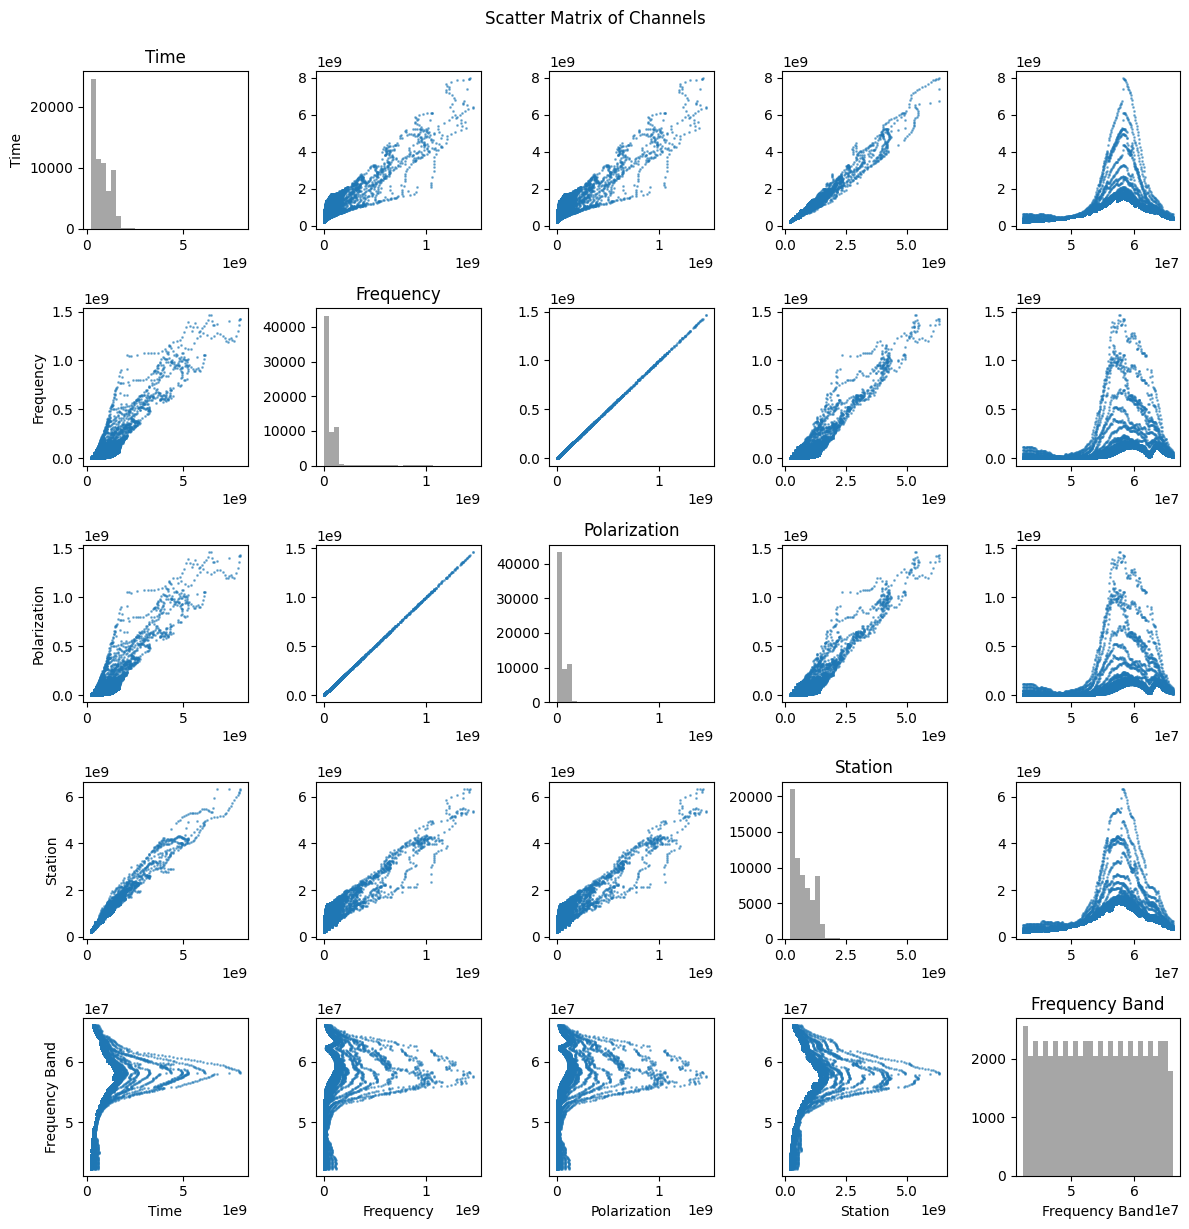

In [82]:
create_pairs_plot(time_flatten_solar_idx, frequency_flatten_solar_idx, polarization_flatten_solar_idx, baseline_flatten_solar_idx, freq_band_flatten_solar_idx)

## source_in_sidelobes

In [83]:
data_source, labels_source, ids_source, source_source, freq_band_source = load_h5_data(file_path, "anomaly_data/source_in_sidelobes")

In [131]:
print(np.where(np.isnan(data_source)))
print(np.where(np.isnan(freq_band_source)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [84]:
stat_summ_print(data_source, labels_source, ids_source, source_source, freq_band_source)

Data Shape: (446, 256, 256, 4)
Summary for Data: Min:10.829456329345703, Max:420140613632.0, Mean: 189524912.0, Std: 2881615360.0
Summary for Frequency Band: Min:119942096.0, Max:187304688.0, Mean: 145783200.0, Std: 15523977.0
Number of Unique Sources: 446
Label: source_in_sidelobes, ID Counts: 446


In [85]:
time_flatten_source, frequency_flatten_source, polarization_flatten_source, baseline_flatten_source, freq_band_flatten_source = flatten_data(data_source, freq_band_source)

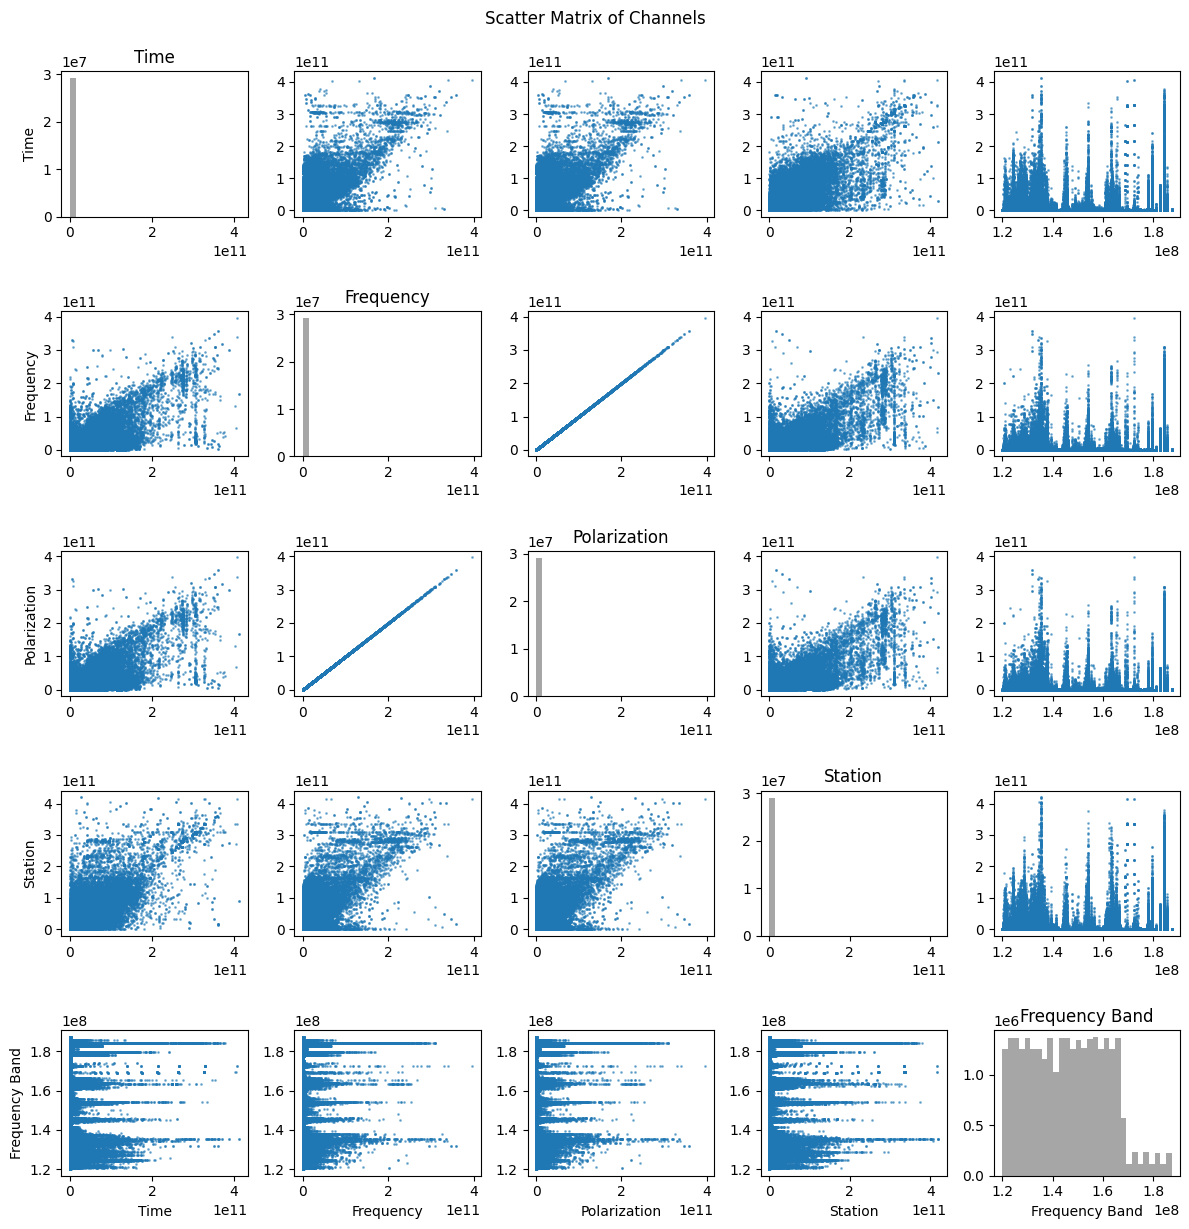

In [86]:
create_pairs_plot(time_flatten_source, frequency_flatten_source, polarization_flatten_source, baseline_flatten_source, freq_band_flatten_source)

In [87]:
time_flatten_source_idx, frequency_flatten_source_idx, polarization_flatten_source_idx, baseline_flatten_source_idx, freq_band_flatten_source_idx = flatten_data_index(data_source,freq_band_source, 0)

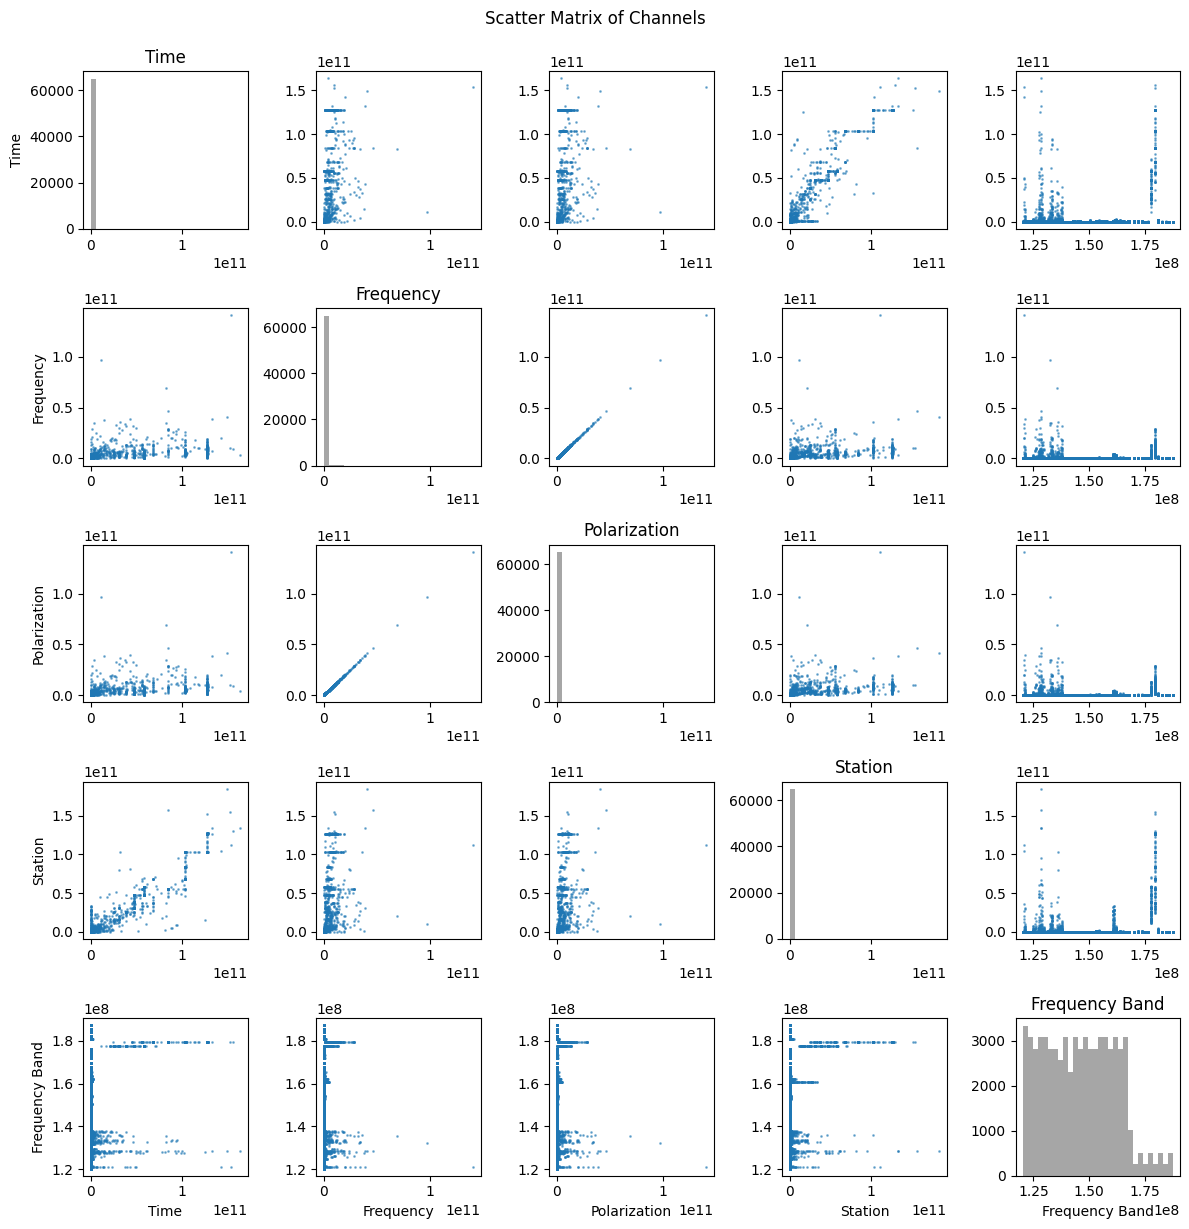

In [88]:
create_pairs_plot(time_flatten_source_idx, frequency_flatten_source_idx, polarization_flatten_source_idx, baseline_flatten_source_idx, freq_band_flatten_source_idx)

## third_order_data_loss

In [89]:
data_third, labels_third, ids_third, source_third, freq_band_third = load_h5_data(file_path, "anomaly_data/third_order_data_loss")

In [132]:
print(np.where(np.isnan(data_third)))
print(np.where(np.isnan(freq_band_third)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [90]:
stat_summ_print(data_third, labels_third, ids_third, source_third, freq_band_third)

Data Shape: (283, 256, 256, 4)
Summary for Data: Min:0.0, Max:530186240000.0, Mean: 242264224.0, Std: 3269058048.0
Summary for Frequency Band: Min:30078124.0, Max:187304688.0, Mean: 130889792.0, Std: 36786252.0
Number of Unique Sources: 283
Label: third_order_data_loss, ID Counts: 283


In [91]:
time_flatten_third, frequency_flatten_third, polarization_flatten_third, baseline_flatten_third, freq_band_flatten_third = flatten_data(data_third, freq_band_third)

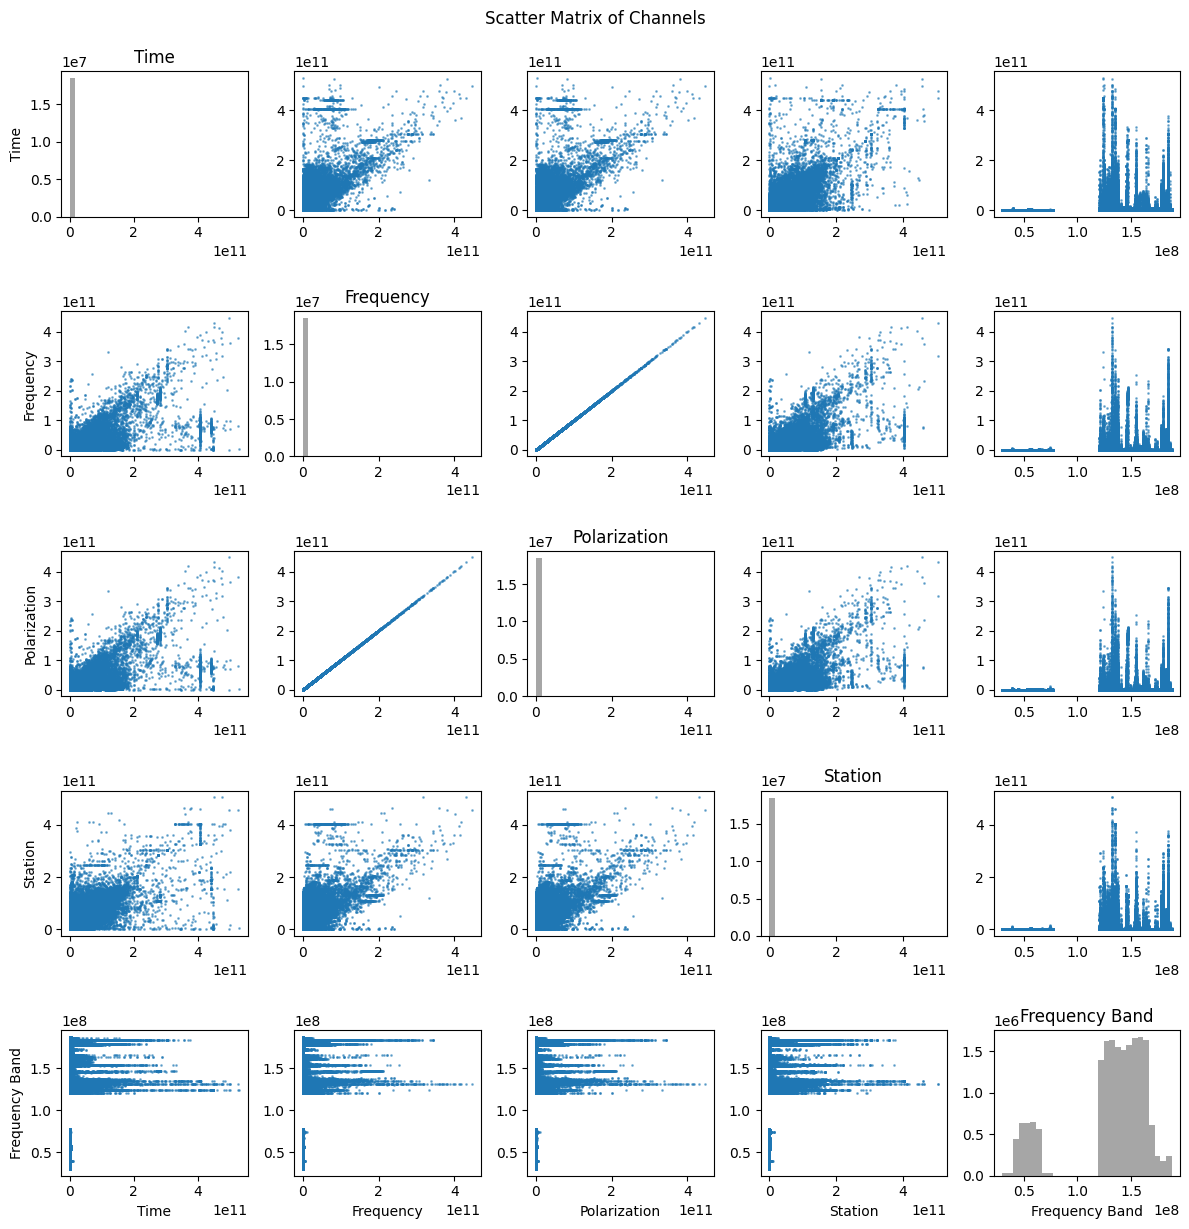

In [92]:
create_pairs_plot(time_flatten_third, frequency_flatten_third, polarization_flatten_third, baseline_flatten_third, freq_band_flatten_third)

In [96]:
time_flatten_third_idx, frequency_flatten_third_idx, polarization_flatten_third_idx, baseline_flatten_third_idx, freq_band_flatten_third_idx = flatten_data_index(data_third,freq_band_third, 0)

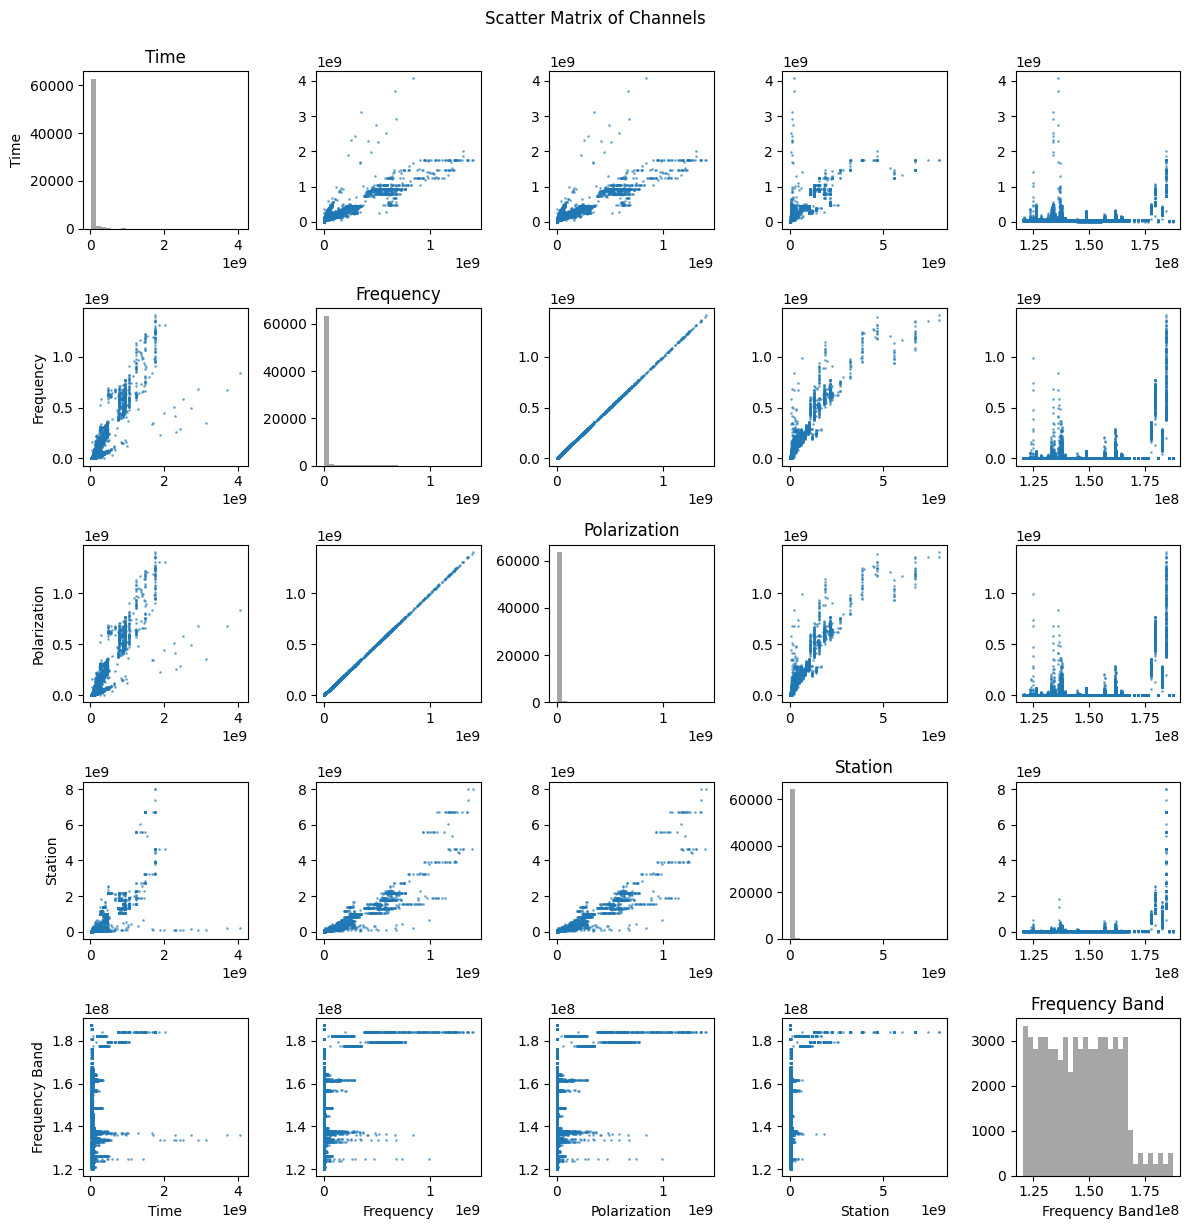

In [97]:
create_pairs_plot(time_flatten_third_idx, frequency_flatten_third_idx, polarization_flatten_third_idx, baseline_flatten_third_idx, freq_band_flatten_third_idx)

## Train

In [95]:
data_train, labels_train, ids_train, source_train, freq_band_train = load_h5_data(file_path, "/train_data")


In [133]:
print(np.where(np.isnan(data_train)))
print(np.where(np.isnan(freq_band_train)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [98]:
time_flatten_train, frequency_flatten_train, polarization_flatten_train, baseline_flatten_train, freq_band_flatten_train = flatten_data_index(data_train, freq_band_train, 0)


In [99]:
stat_summ_print(time_flatten_train, frequency_flatten_train, polarization_flatten_train, baseline_flatten_train, freq_band_flatten_train)

Data Shape: (65536,)
Summary for Data: Min:60151868.0, Max:91504607232.0, Mean: 583040896.0, Std: 4529767424.0
Summary for Frequency Band: Min:120312496.0, Max:187304688.0, Mean: 145762320.0, Std: 15503104.0
Number of Unique Sources: 65536
Label: 2627638.75, ID Counts: 65536


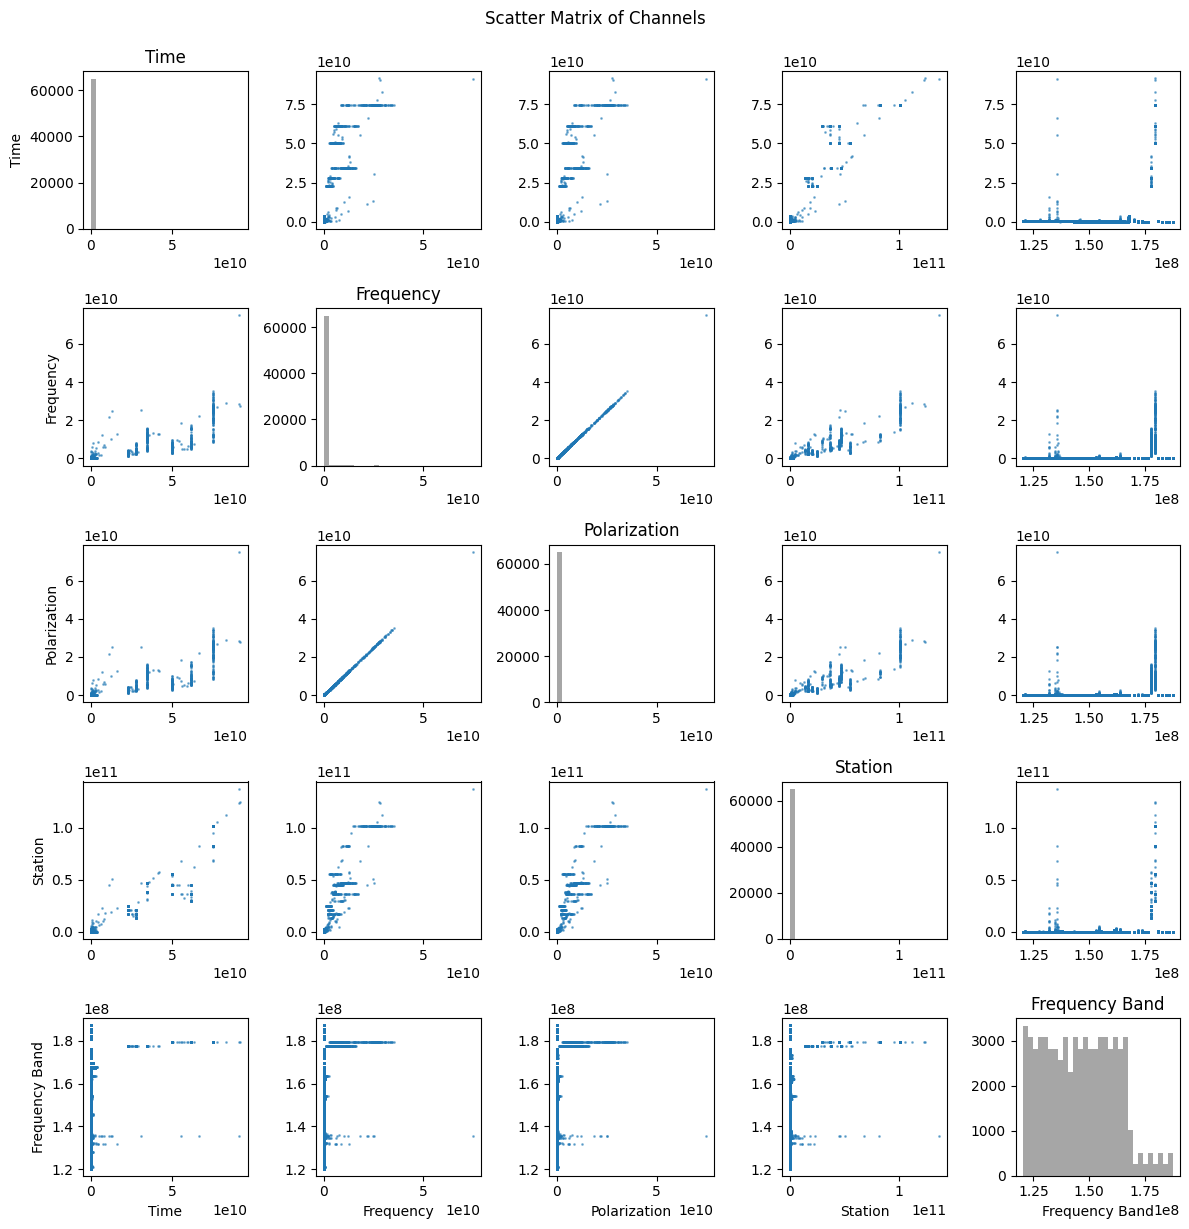

In [100]:
create_pairs_plot(time_flatten_train, frequency_flatten_train, polarization_flatten_train, baseline_flatten_train, freq_band_flatten_train)

# Heatmap Comparison

## Comparing Training data frequency to Anomaly data frequency

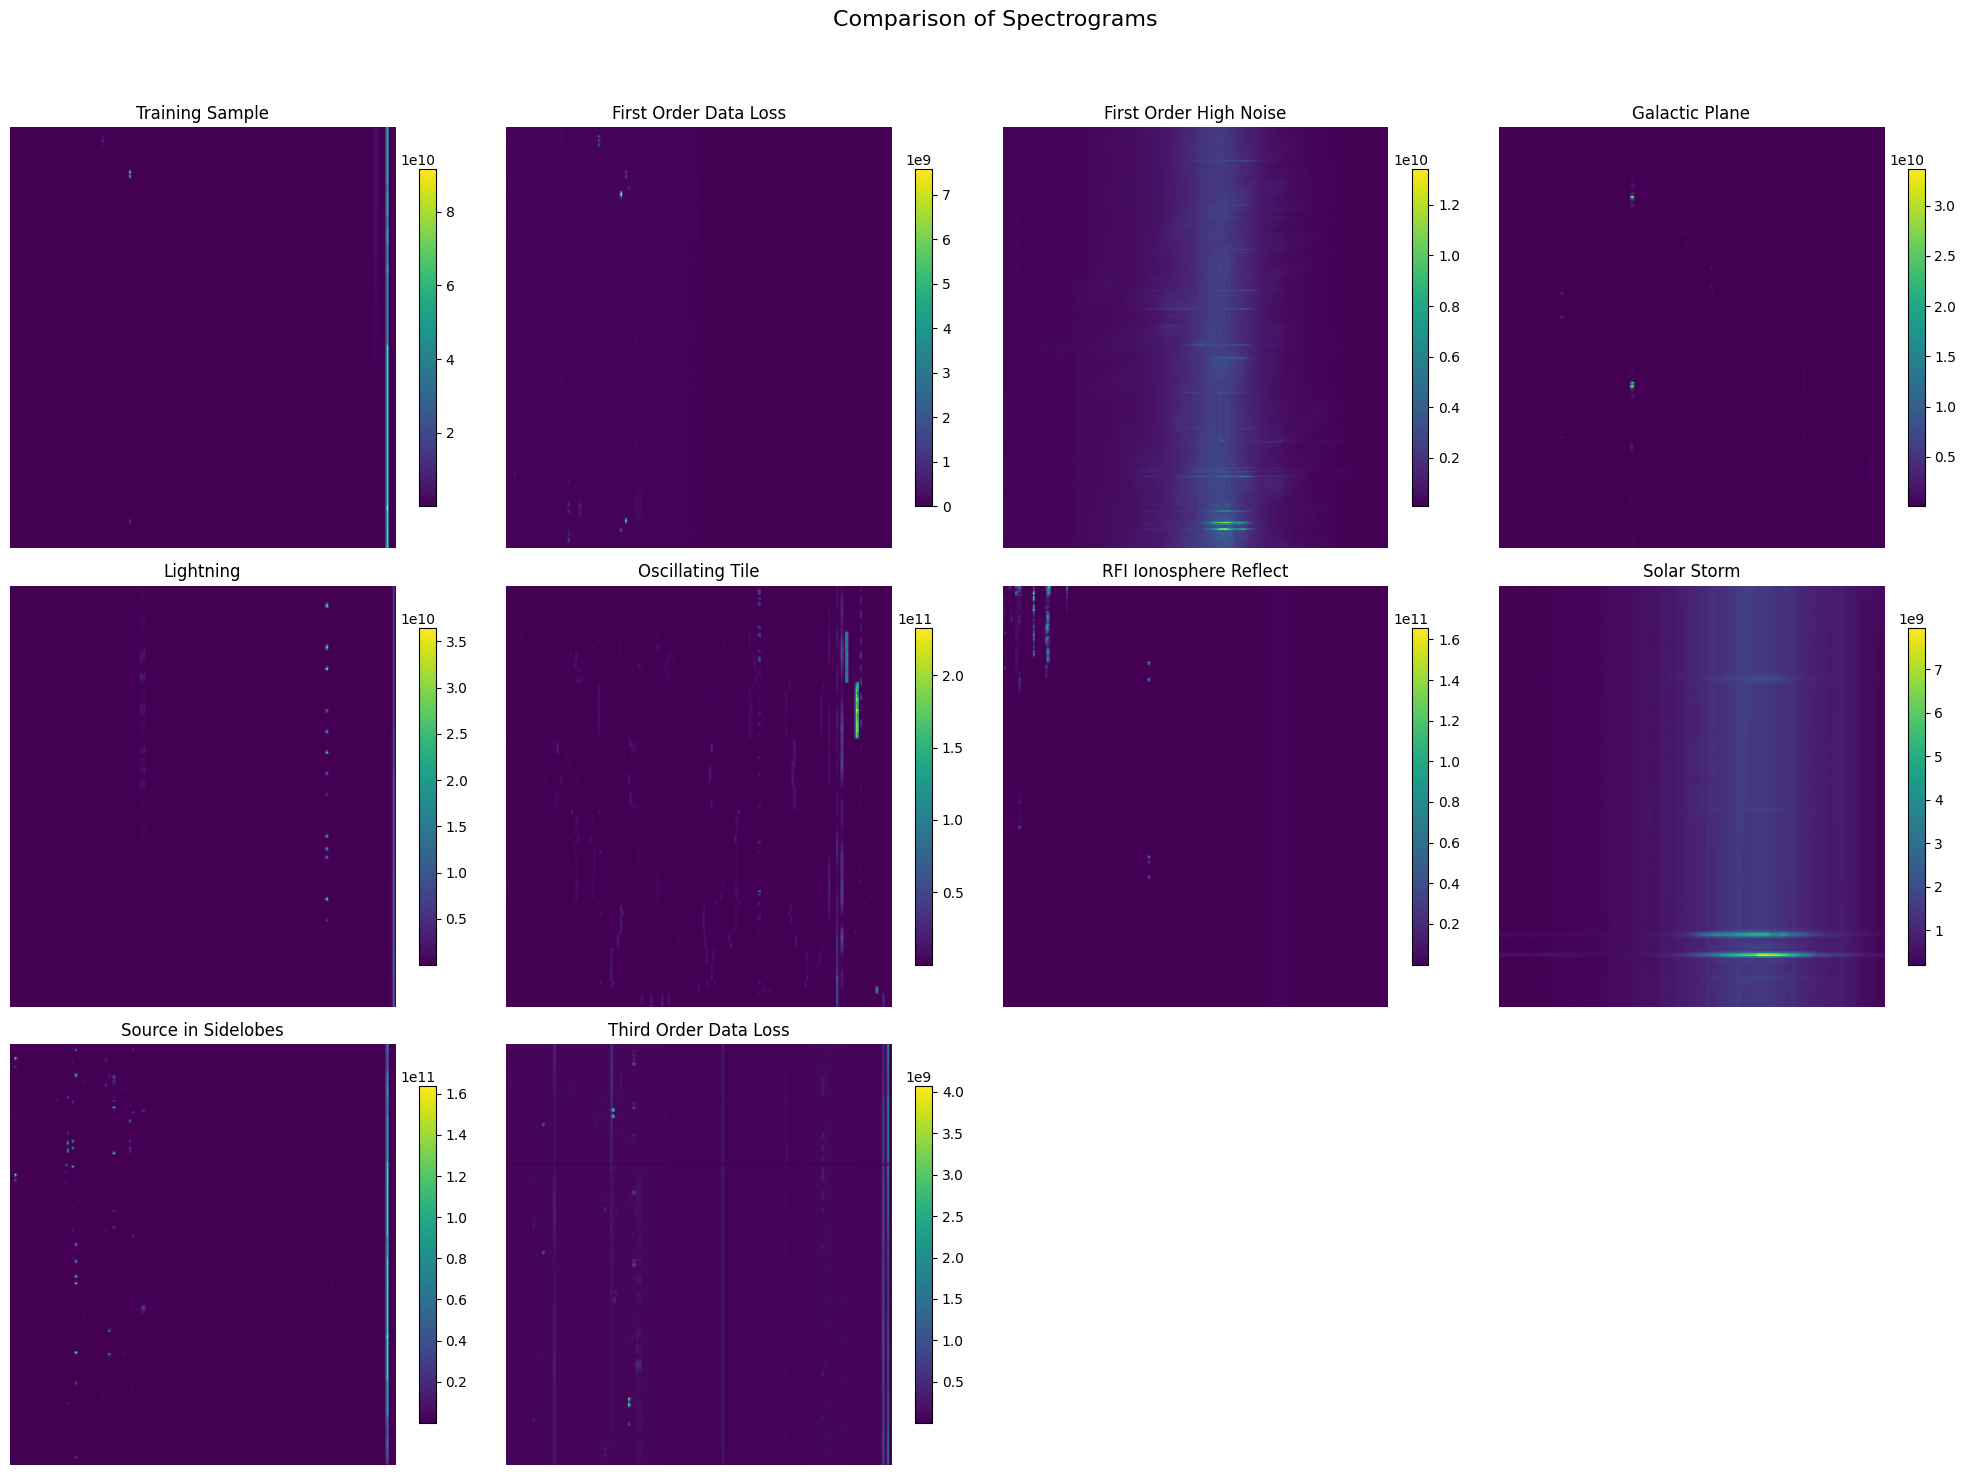

In [115]:
random_value = 0
datasets = [
    (data_train[random_value, :, :, 0], "Training Sample"),
    (data_data_loss[random_value, :, :, 0], "First Order Data Loss"),
    (data_high_noise[random_value, :, :, 0], "First Order High Noise"),
    (data_galactic_plane[random_value, :, :, 0], "Galactic Plane"),
    (data_lightning[random_value, :, :, 0], "Lightning"),
    (data_oscillating_tile[random_value, :, :, 0], "Oscillating Tile"),
    (data_rfi[random_value, :, :, 0], "RFI Ionosphere Reflect"),
    (data_solar[random_value, :, :, 0], "Solar Storm"),
    (data_source[random_value, :, :, 0], "Source in Sidelobes"),
    (data_third[random_value, :, :, 0], "Third Order Data Loss"),
]

# Create a grid layout for subplots
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))  # Adjust figsize for larger layout
fig.suptitle("Comparison of Spectrograms", fontsize=16)

# Loop through datasets and plot
for idx, (data, title) in enumerate(datasets):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    im = ax.imshow(data, aspect='auto', cmap='viridis', origin='lower')
    ax.set_title(title, fontsize=12)
    ax.axis('off')  # Optional: Remove axes for a cleaner look
    fig.colorbar(im, ax=ax, shrink=0.8)

# Remove any empty subplots (if the number of datasets < rows * cols)
for idx in range(len(datasets), rows * cols):
    fig.delaxes(axes[idx // cols, idx % cols])

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


## Comparing Training frequency band to Anomaly frequency band

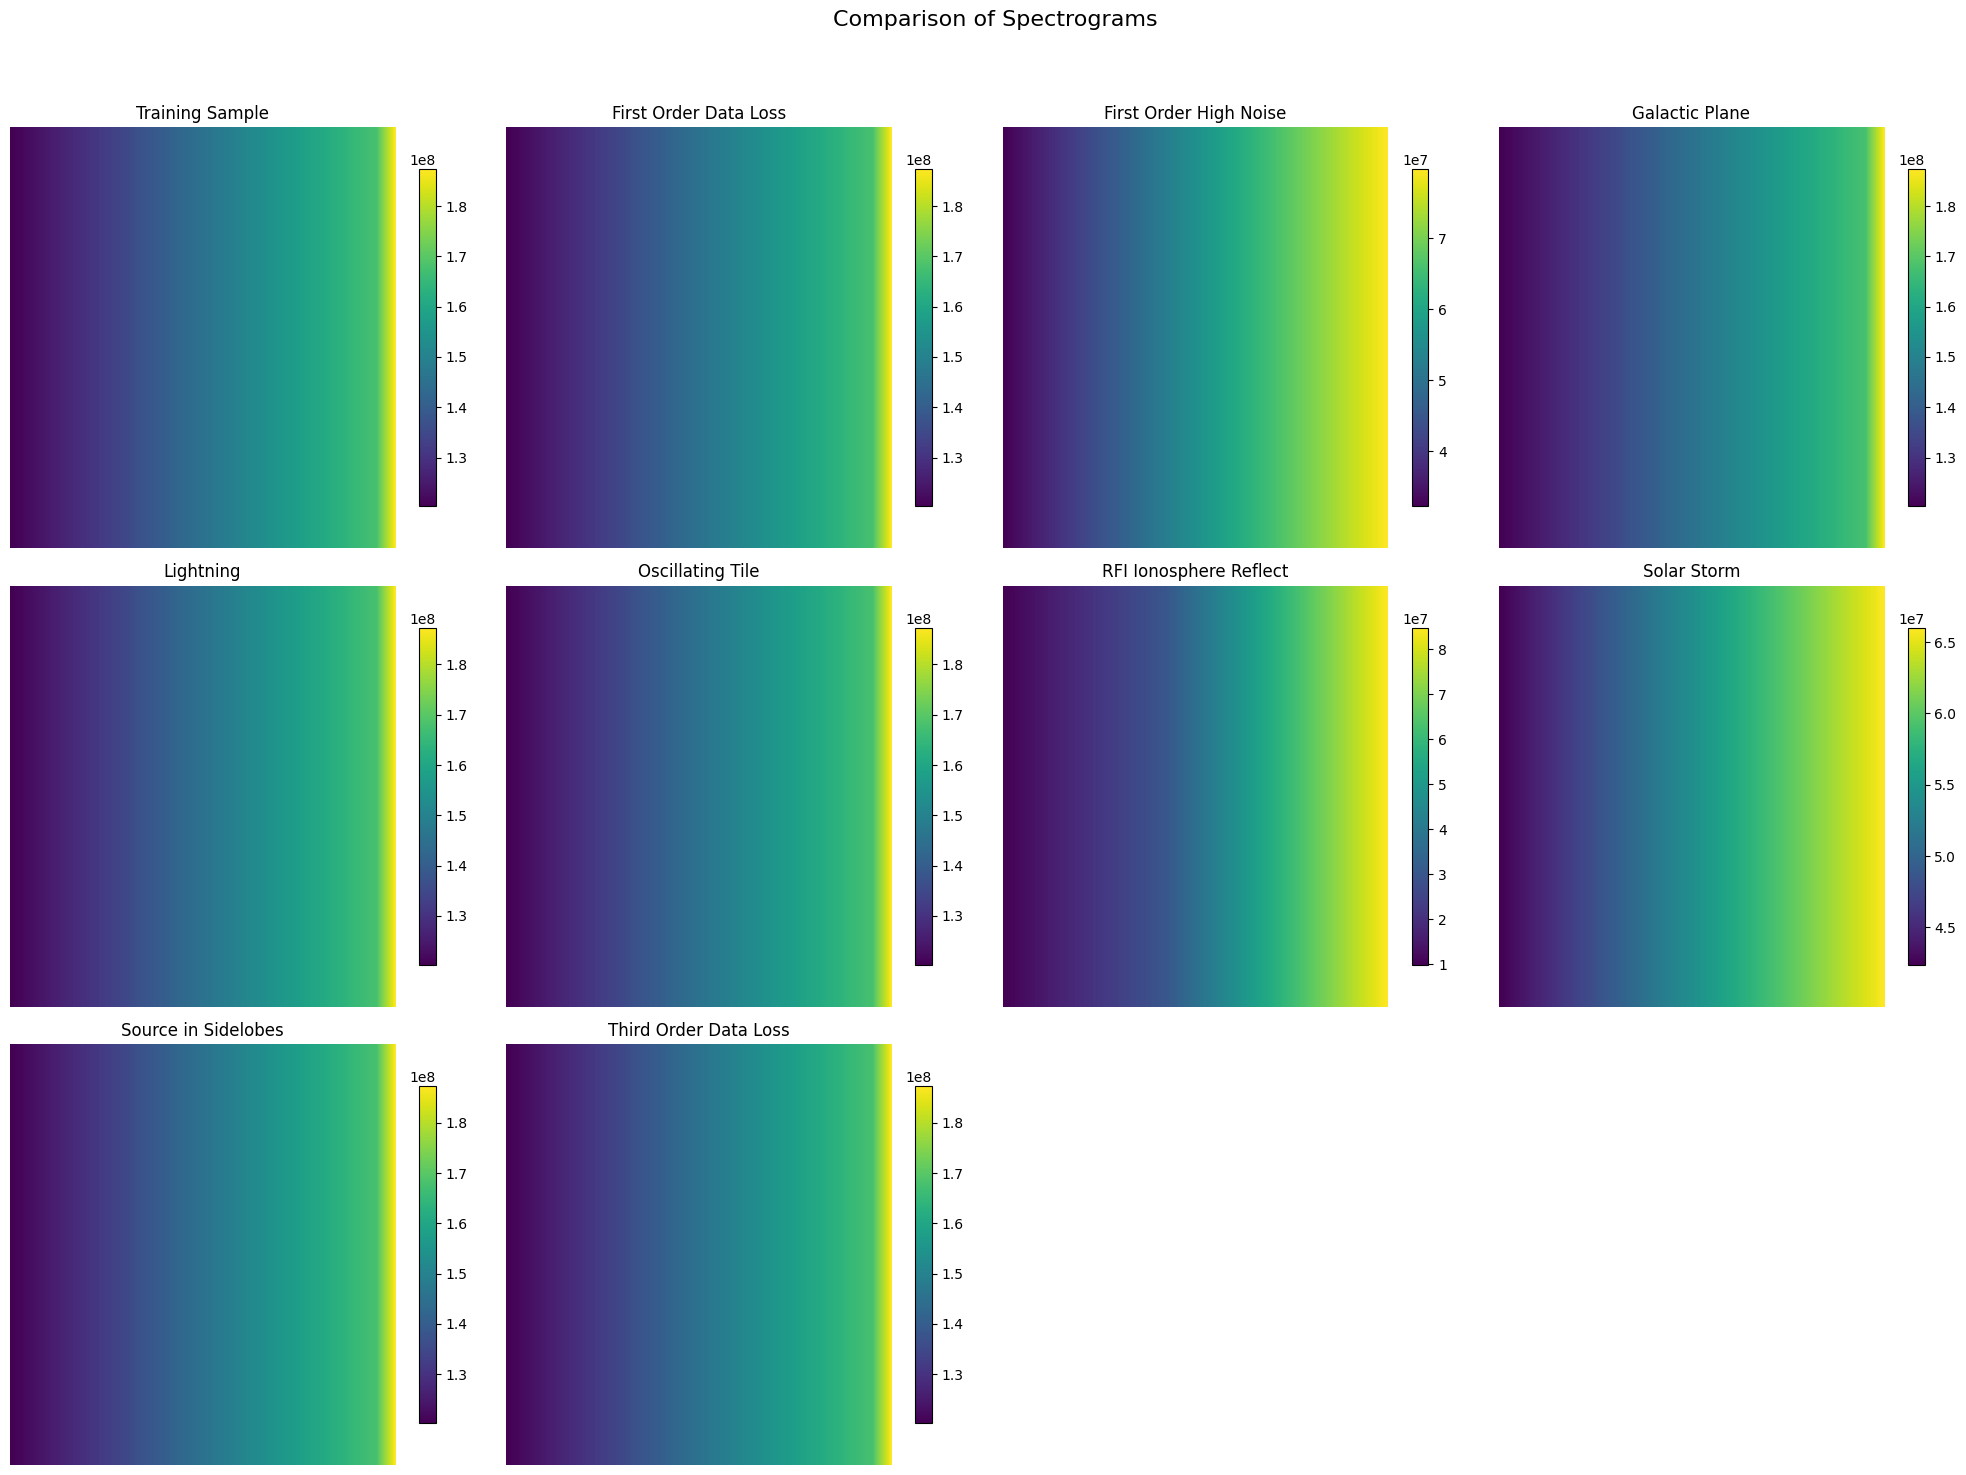

In [116]:
ran_value = 0
datasets = [
    (freq_band_train[ran_value, :, :, 0], "Training Sample"),
    (freq_band_data_loss[ran_value, :, :, 0], "First Order Data Loss"),
    (freq_band_high_noise[ran_value, :, :, 0], "First Order High Noise"),
    (freq_band_galactic_plane[ran_value, :, :, 0], "Galactic Plane"),
    (freq_band_lightning[ran_value, :, :, 0], "Lightning"),
    (freq_band_oscillating_tile[ran_value, :, :, 0], "Oscillating Tile"),
    (freq_band_rfi[ran_value, :, :, 0], "RFI Ionosphere Reflect"),
    (freq_band_solar[ran_value, :, :, 0], "Solar Storm"),
    (freq_band_source[ran_value, :, :, 0], "Source in Sidelobes"),
    (freq_band_third[ran_value, :, :, 0], "Third Order Data Loss"),
]

# Create a grid layout for subplots
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))  # Adjust figsize for larger layout
fig.suptitle("Comparison of Frequency Bands", fontsize=16)

# Loop through datasets and plot
for idx, (data, title) in enumerate(datasets):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    im = ax.imshow(data, aspect='auto', cmap='viridis', origin='lower')
    ax.set_title(title, fontsize=12)
    ax.axis('off')  # Optional: Remove axes for a cleaner look
    fig.colorbar(im, ax=ax, shrink=0.8)

# Remove any empty subplots (if the number of datasets < rows * cols)
for idx in range(len(datasets), rows * cols):
    fig.delaxes(axes[idx // cols, idx % cols])

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()
